# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### Общая информация
Дата выдачи: 16.11.2024

Мягкий дедлайн: 28.11.2024

Жесткий дедлайн: 02.12.2024

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку.

**Оценка**: 11.5

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи

Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-linclass-__Username__.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-linclass-__IvanovIvan__.ipynb).

# Часть 1. SVM, LR и калибровка вероятностей (2 балла + 0.5 бонус)

In [ ]:
import numpy as np
import pandas as pd
# import polars as pl
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
# pl.Config().set_tbl_rows(100)
# pl.Config().set_tbl_cols(100)

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт случайный ответ. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [ ]:
from sklearn.dummy import DummyClassifier
random_classifier = DummyClassifier(strategy='uniform', random_state=42).fit(X_train, y_train)
y_random = random_classifier.predict_proba(X_test)[:,1]
y_random

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

**Вопрос:** решаем задачу бинарной классификации, но y\_random содержит какие-то дробные числа, а не 0/1. Почему?



**Ответ**: как написано в описании метода, **predict_proba** возвращает оценку вероятности того, что объект находится в классе 1.

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно.

In [ ]:
from sklearn.metrics import average_precision_score

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

Random Classifier metrics
AUC-PR: 0.5057
AUC-ROC: 0.5000


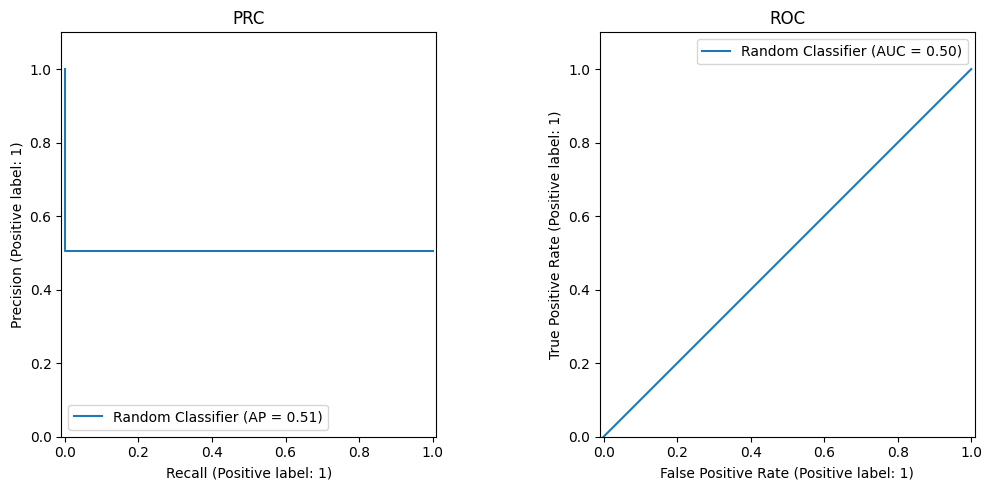

In [ ]:
def depict_pr_roc(y_true, y_pred, classifier_name='Some Classifier', ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 2, figsize=(11, 5))

    print(classifier_name, 'metrics')
    PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name)
    print('AUC-PR: %.4f' % average_precision_score(y_true, y_pred))
    ax[0].set_title("PRC")
    ax[0].set_ylim(0, 1.1)

    RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name)
    print('AUC-ROC: %.4f' % roc_auc_score(y_true, y_pred))
    ax[1].set_title("ROC")
    ax[1].set_ylim(0, 1.1)

    plt.tight_layout()
    plt.legend()


depict_pr_roc(y_test, y_random, 'Random Classifier')

In [ ]:
# dataframe для сравнения
# методов классификации по метрикам
df_metrics = pd.DataFrame(
    columns=['auc_pr', 'roc_auc_score', 'reg_const']
)
precision, recall, _ = precision_recall_curve(y_test, y_random)
# добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
      average_precision_score(y_test, y_random),
      roc_auc_score(y_test, y_random),
      0,
]

# по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,auc_pr,roc_auc_score,reg_const
Random Classifier,0.505667,0.5,0.0


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов.

Подберите параметр регуляризации `C` с точки зрения AUC-PR (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).


In [ ]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

c = np.logspace(-2, 3, 20)
searcher = GridSearchCV(LinearSVC(), [{"C": c}], cv=10)
searcher.fit(X_train, y_train)
best_c = searcher.best_params_['C']
print(best_c)

0.01


  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR

In [ ]:
model_svc = LinearSVC(C = best_c)
model_svc.fit(X_train, y_train)
y_svc = model_svc.decision_function(X_test)

Linear SVC metrics
AUC-PR: 0.8299
AUC-ROC: 0.8476


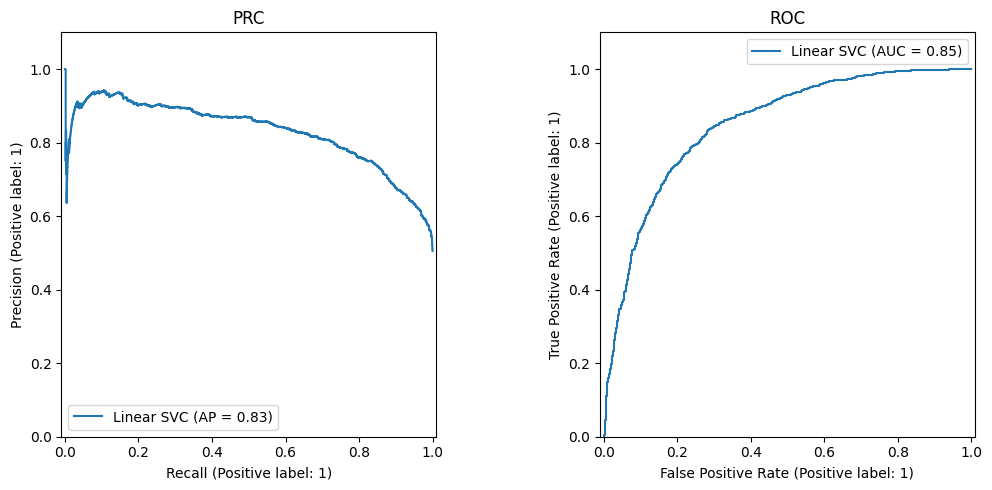

In [ ]:
depict_pr_roc(y_test, y_svc, 'Linear SVC')

In [ ]:
df_metrics.loc['Linear SVC'] = [
      average_precision_score(y_test, y_svc),
      roc_auc_score(y_test, y_svc),
      best_c,
]

Проанализируйте, как себя ведут обе кривые:
- Что происходит при увеличении порога? Как бы вы это проинтерпретировали?
- Монотонные ли кривые? Как вы это объясните?

- PRC - при росте порога с небольшими флуктуациями возрастает до определенного момента, где после происходят резкие флуктуации и в итоге оказывается в (1,0). Объяснется это тем, что в среднем при росте порога падает recall из-за ув. FN, растет precion из-за ум. FP. Однако, возможны флуктуации, когда FN растет быстрее, чем падет FP. Функция немонотонна.
- ROC - при росте порога падают обе метрики. Функция монотонно возрастающая. Объяснимо тем, что при росте порога FP уменьшается, TP растет, а в каждой из метрик они делятся на общее число элементов в классе.  

Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

In [ ]:
df_metrics

,auc_pr,roc_auc_score,reg_const
Random Classifier,0.505667,0.500000,0.00
Linear SVC,0.829864,0.847623,0.01


Выросли обе метрики, что неудивительно, так как почти любая адекватная модель будет лучше, чем случайная.

__Logistic Regression__


Аналогичное задание для логистической регрессии с L2 регуляризатором:


*   подберите гиперпараметр C, используя метрику AUC-PR
*   нарисуйте ROC, PR кривые для тестовой части
*   выведите метрики для тестовых данных и сравните их с результатами случайного классификатора



In [ ]:
from sklearn.linear_model import LogisticRegression

searcher = GridSearchCV(LogisticRegression(), [{"penalty": ['l2'], 'C':c}], cv=10)
searcher.fit(X_train, y_train)
best_c = searcher.best_params_['C']
print(best_c)

0.018329807108324356


In [ ]:
model_log = LogisticRegression(penalty = 'l2',C = best_c)
model_log.fit(X_train, y_train)
y_log = model_log.predict_proba(X_test)[:,1]

Logistic Regression metrics
AUC-PR: 0.8298
AUC-ROC: 0.8477


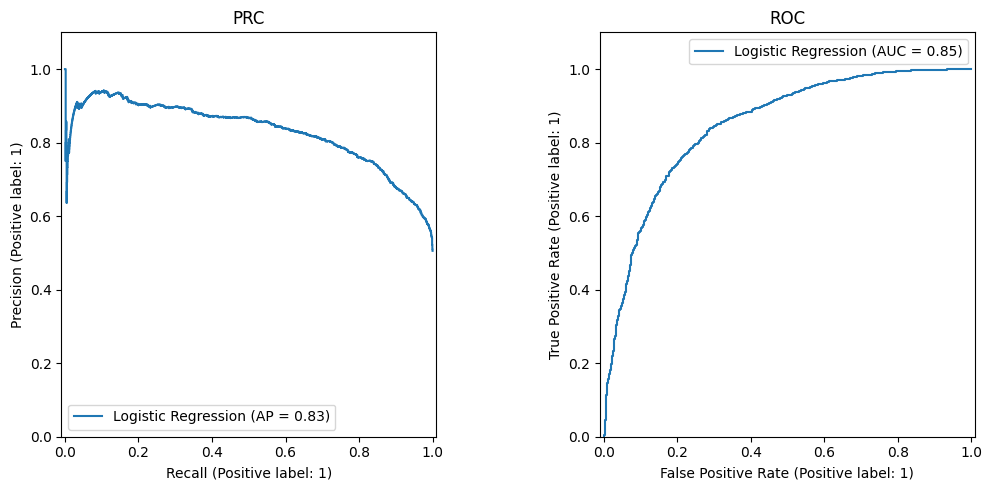

In [ ]:
depict_pr_roc(y_test, y_log, 'Logistic Regression')

In [ ]:
df_metrics.loc['Logistic Regression'] = [
      average_precision_score(y_test, y_log),
      roc_auc_score(y_test, y_log),
      best_c,
]
df_metrics

,auc_pr,roc_auc_score,reg_const
Random Classifier,0.505667,0.500000,0.00000
Linear SVC,0.829864,0.847623,0.01000
Logistic Regression,0.829766,0.847719,0.01833


Аналогично, обе метрики выросли.

Нарисуйте ROC, PR кривые для тестовой части для всех 3 классификаторов на одном графике

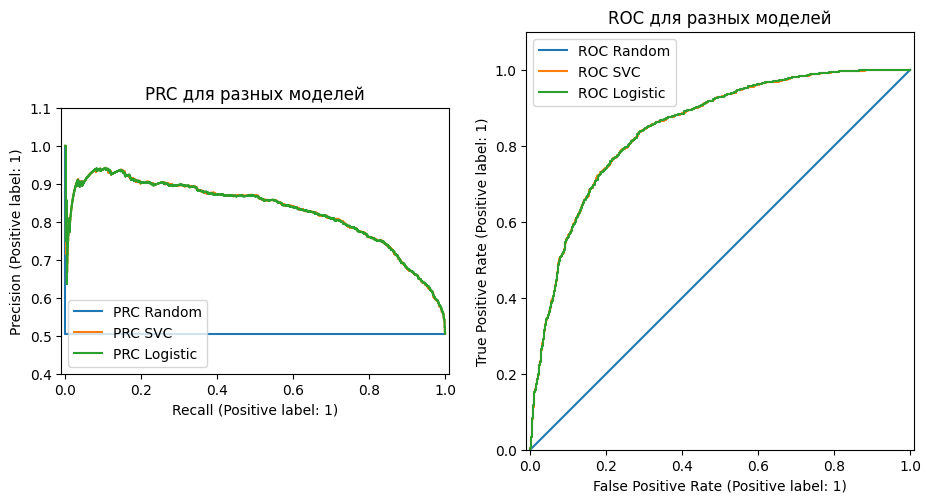

In [ ]:
    fig, ax = plt.subplots(1, 2, figsize=(11, 8))

    PrecisionRecallDisplay.from_predictions(y_test, y_random, ax=ax[0], label='PRC Random')
    PrecisionRecallDisplay.from_predictions(y_test, y_svc, ax=ax[0], label='PRC SVC')
    PrecisionRecallDisplay.from_predictions(y_test, y_log, ax=ax[0], label='PRC Logistic')

    RocCurveDisplay.from_predictions(y_test, y_random, ax=ax[1], label='ROC Random')
    RocCurveDisplay.from_predictions(y_test, y_svc, ax=ax[1], label='ROC SVC')
    RocCurveDisplay.from_predictions(y_test, y_log, ax=ax[1], label='ROC Logistic')

    ax[0].set_title("PRC для разных моделей")
    ax[1].set_title("ROC для разных моделей")
    ax[0].set_ylim(0.4, 1.1)
    ax[1].set_ylim(0, 1.1)
    plt.legend()

**Вопрос:** Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).



**Ответ:** отличия минимальны, а те что есть банально объясняются разными функциями потерь.

#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)



В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

* Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. Не забудьте зафиксировать seed для воспроизводимости

* Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы. Ниже есть шаблоны, можете воспользоваться ими, либо написать своё

In [ ]:
X, y = make_classification(
    n_samples=1000, n_features=2, n_informative=2, n_redundant=0, random_state=42
)
c = np.logspace(-2, 3, 20)
searcher = GridSearchCV(LinearSVC(), [{"C": c}], cv=10)
searcher.fit(X, y)
model = LinearSVC(C = searcher.best_params_['C'])
model.fit(X, y)

LinearSVC(C=0.01)

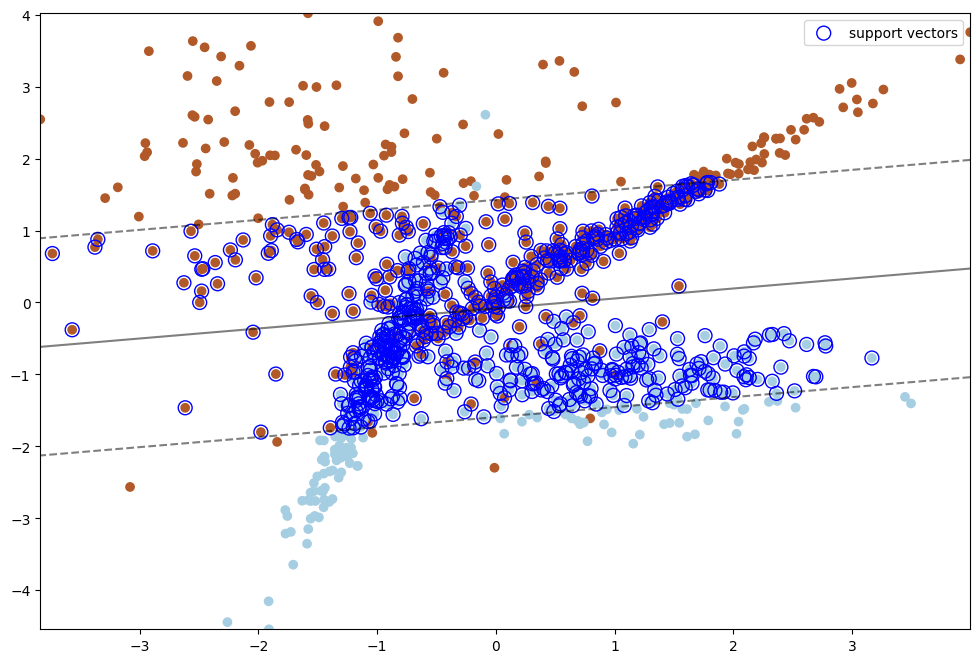

In [ ]:
def plot_svm_2D(X, y, model,  plot_support=True):

    # создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 30)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    # Ответы модели для сетки для отрисовки разделяющей прямой
    Z = model.decision_function(xy).reshape(XX.shape)

    plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

    # Отрисовали выборку
    plt.scatter(
         X[:,0], X[:,1], c=y, cmap=plt.cm.Paired
    )

    # Отрисовали опорные векторы
    # источник: https://scikit-learn.org/dev/auto_examples/svm/plot_linearsvc_support_vectors.html#sphx-glr-auto-examples-svm-plot-linearsvc-support-vectors-py
    support_vector_indices = np.where(np.abs(model.decision_function(X)) <= 1 + 1e-15)[0]
    support_vectors = X[support_vector_indices]
    if plot_support:
        plt.scatter(
            support_vectors[:, 0],
            support_vectors[:, 1],
            label='support vectors',
            s=100,
            linewidth=1,
            edgecolor="blue",
            facecolors='none'
        )

    plt.legend()
fig=plt.figure(figsize=(12,8))
plot_svm_2D(X, y, model)

**Вопрос:** какие объекты выделяются как "опорные"?



**Ответ:** те, которые находятся на расстоянии < 1 от разделяющей прямой, то есть те объекты за которые мы "штрафуем" функцию потерь.

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты.

In [ ]:
searcher = GridSearchCV(LogisticRegression(), [{"penalty": ['l2'], 'C':c}], cv=10)
searcher.fit(X, y)
model = LogisticRegression(penalty = 'l2', C = searcher.best_params_['C'])
model.fit(X, y)

LogisticRegression(C=0.018329807108324356)

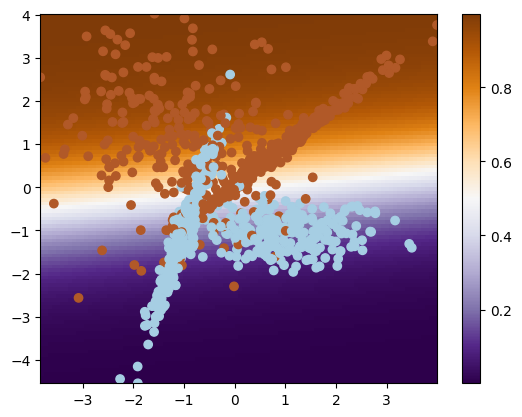

In [ ]:
def plot_logreg_2D(X, y, model):

    # создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 100)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    # Ответы модели для сетки для отрисовки распределения
    Z = model.predict_proba(xy)[:,1]
    Z = Z.reshape((xx.shape[0], -1)).T

    image = plt.imshow(
        Z,
        interpolation='nearest',
        extent=(xx.min(), xx.max(), yy.min(), yy.max()),
        aspect='auto',
        origin='lower',
        cmap=plt.cm.PuOr_r
    )

    #Отрисовали выборку
    plt.scatter(
         X[:,0], X[:,1], c=y, cmap=plt.cm.Paired
    )

    plt.colorbar(image)

plot_logreg_2D(X, y, model)

**Вопрос:** Как на картинке визуализирована область, где модель не уверена ($p(y=+1|x) = 0.5$)? Как это обосновать теоритечески?



**Ответ:** В виде белой размытой линии. Собственно это и есть искомая гиперплоскость, чем ближе к которой тем меньше уверенность модели.

#### __Задание 2. Калибровка вероятностей__ (1 балл)



Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность?

Хорошо откалиброванный  классификатор должен выдавать значения так, чтобы среди образцов, для которых он дал значение, близкое к $\alpha$, примерно $\alpha * 100 \%$ фактически принадлежали к положительному классу. (Например, если классификатор выдает 0.3 для некоторых, то 30% из них должны принадлежать классу 1)

Для построения калибровочной криовой используем следующий алгоритм:

Разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [ ]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2)
        if len(y_test[(preds >= l) & (preds < r)]) != 0:
          bin_real_ratios.append(np.sum(y_test[(preds >= l) & (preds < r)] == 1)/len(y_test[(preds >= l) & (preds < r)]))
        else:
          bin_real_ratios.append(0)
    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.ylim([-0.05, 1.05])
    plt.grid()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

Отрисуйте калибровочную кривую идеально откалиброванной модели (диагональ)

In [ ]:
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
searcher = GridSearchCV(LogisticRegression(), [{"penalty": ['l2'], 'C':c}], cv=10)
searcher.fit(X_train, y_train)
model_log = LogisticRegression(penalty = 'l2',C = searcher.best_params_['C'])
model_log.fit(X_train, y_train)
p_log = model_log.predict_proba(X_test)[:,1]

In [ ]:
searcher = GridSearchCV(LinearSVC(), [{"C": c}], cv=10)
searcher.fit(X_train, y_train)
model_svc = LinearSVC(C = searcher.best_params_['C'])
model_svc.fit(X_train, y_train)
p_svc = 1/(1 + np.exp(-2*model_svc.decision_function(X_test)))
p_svc

array([0.65279997, 0.03873372, 0.24688362, ..., 0.11777809, 0.79282951,
       0.86809391])

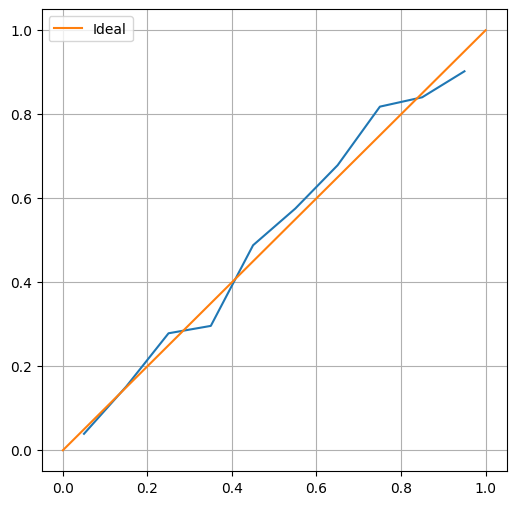

In [ ]:
plot_calibration_curve(y_test, p_log)
plt.plot([0, 1], [0,1],label='Ideal')
plt.legend()

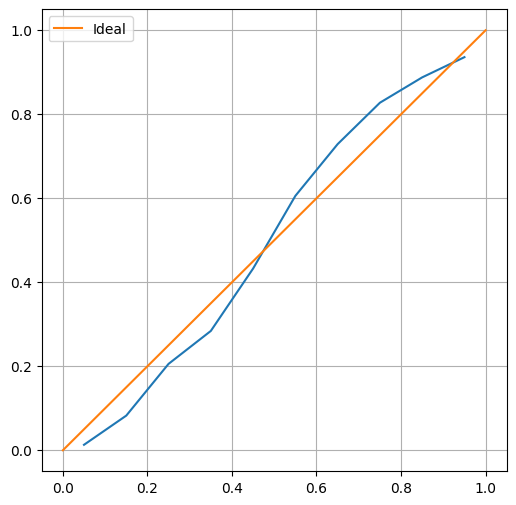

In [ ]:
plot_calibration_curve(y_test, p_svc)
plt.plot([0, 1], [0,1],label='Ideal')
plt.legend()

**Вопрос**: хорошо ли откалиброваны кривые для SVM, логистической регрессии? Подумайте, как это следует из вида кривой

**Ответ:** Мне кажется, что да. Так как обе кривые достаточно близки к диагональной. Исходя из критерия "похожести", предполагаю, что логистическая регрессия лучше откалибрована.

Из формальных способов в этом убедиться есть знакомый вам LogLoss, который напрямую оценивает вероятности,
$$\text{LogLoss} = -\frac{1}{N}\sum_{i} \sum_{k \in {0. 1}}\log p_k[y_i = k]$$
а так же BrierScore, который подсчитывает отклонение между получившейся вероятностью и реальным значением таргета.
$$\text{BrierScore} = \frac{1}{N}\sum_{i} (p_i - y_i)^2$$
Посмотрите на них тоже и сделайте вывод

In [ ]:
from sklearn.metrics import log_loss
print('Logistic: ', log_loss(y_test, p_log))
print('SVC: ', log_loss(y_test, p_svc))

Logistic:  0.4859274399426966
SVC:  0.4949057043555775


In [ ]:
from sklearn.metrics import brier_score_loss
print('Logistic: ', brier_score_loss(y_test, p_log))
print('SVC: ', brier_score_loss(y_test, p_svc))

Logistic:  0.15869968171664214
SVC:  0.16178031438797943


Действительно, по обеим метрикам логистическая регрессия угадывает вероятности лучше.

Изучите распределение ответов классификаторов при помощи гистограмм

Text(0.5, 0, 'Probability')

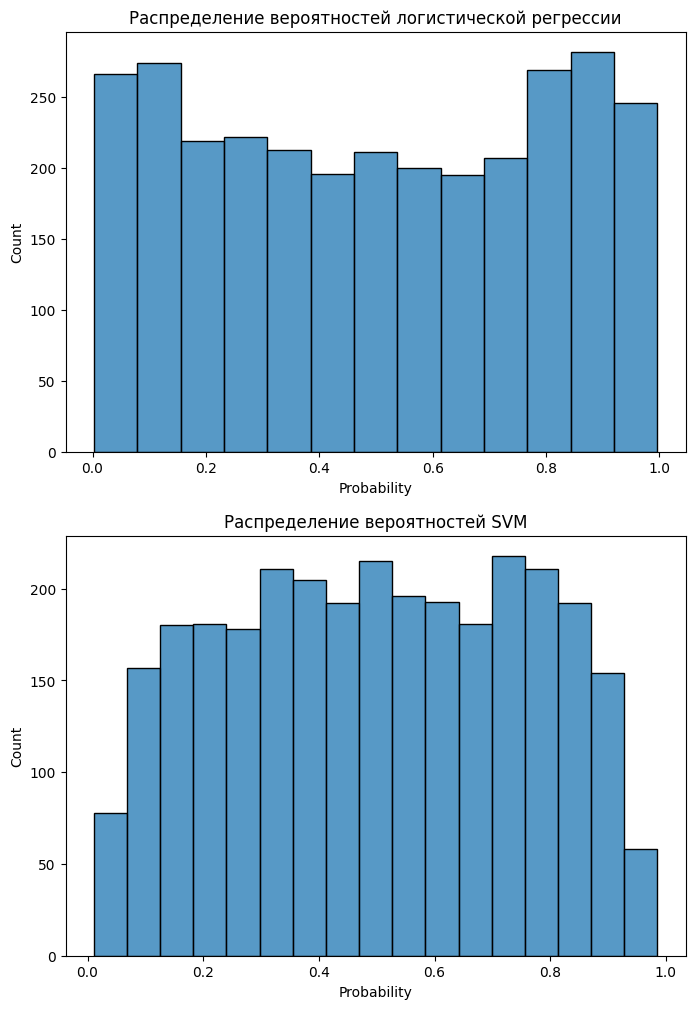

In [ ]:
import seaborn as sns
fig, axes = plt.subplots(2, 1, figsize=(8, 12))
sns.histplot(p_log, ax = axes[0])
sns.histplot(p_svc, ax = axes[1])
axes[0].set_title('Распределение вероятностей логистической регрессии')
axes[1].set_title('Распределение вероятностей SVM')
axes[0].set_xlabel('Probability')
axes[1].set_xlabel('Probability')

**Вопрос:** Чем они различаются? Чем вы можете объяснить это?

**Ответ:** Мы видим, что для логистической регрессии характерны более тяжелые хвосты (но в целом тренда нет), а для SVM вид отдаленно похожий на нормальное распределение. Это можно объяснить тем, что логистическая регрессия пытается приблизить вероятности и из-за этого её распределение будет лучше отражать распределение по выборке (равномерное), а SVM пытается построить гиперплоскость так, чтобы она была как можно удаленнее от ближайший объектов из-за чего возникает "равномерность" объектов по обе стороны, что вероятно и приводит к похожей на нормальную картине.

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью  предсказания для тестовой выборки.

In [ ]:
from sklearn.calibration import CalibratedClassifierCV
model_svc_calibrated = CalibratedClassifierCV(LinearSVC(C = searcher.best_params_['C']))
model_svc_calibrated.fit(X_train, y_train)
p_svc = model_svc_calibrated.predict_proba(X_test)[:,1]

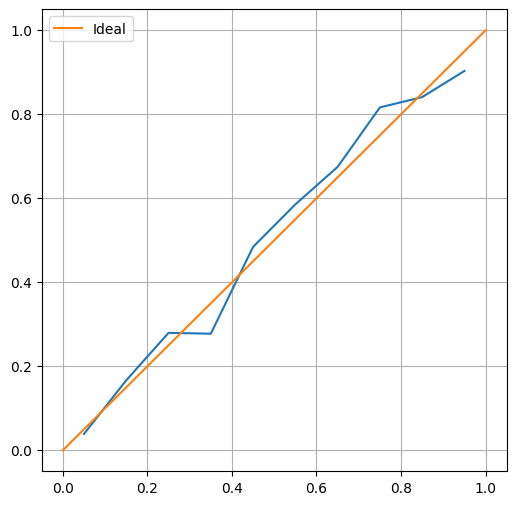

In [ ]:
plot_calibration_curve(y_test, p_svc)
plt.plot([0, 1], [0,1],label='Ideal')
plt.legend()

In [ ]:
print('SVC: ', log_loss(y_test, p_svc))
print('SVC: ', brier_score_loss(y_test, p_svc))

SVC:  0.4861995790558041
SVC:  0.1587336829502776


Text(0.5, 0, 'Probability')

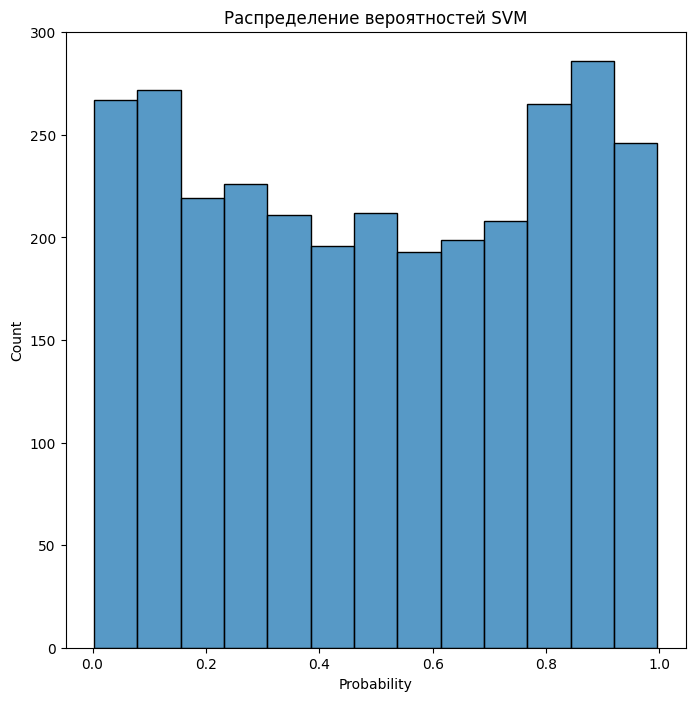

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.histplot(p_svc, ax = ax)
ax.set_title('Распределение вероятностей SVM')
ax.set_xlabel('Probability')

**Вопрос:** Улучшились ли калибровочная кривая и качество калибровки?

**Ответ:** Да, существенно, все еще не дотягивает до логистической (совсем слегка), но гораздо лучше относительно себя.

##### __Бонус: Авторское решение__ (0.5 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

In [ ]:
# your code here

# Часть 2. Обработка категориальных переменных (4 балла + 1.5 бонус)

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла.

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

*(бесценный шаг)*

Разберем датасет [покупок велосипедов](https://www.kaggle.com/datasets/heeraldedhia/bike-buyers/): даны признаки покупателя, требуется предсказать, купит ли он/она велосипед



Замените пропуски в категориальных переменных на новую категорию (`'undefined'`)

Разделите признаки на 2 таблицы: категориальные и числовые признаки

In [ ]:
import kagglehub

path = kagglehub.dataset_download("heeraldedhia/bike-buyers") +  "/bike_buyers.csv"

100%|██████████| 22.2k/22.2k [00:00<00:00, 9.91MB/s]

Extracting files...


In [327]:
# Прочитаем датасет
df = pd.read_csv(path)
df = df.drop(columns = ['ID']) # Сразу выкинем ID, так как не имеет осмысленной связи с целовой переменной
df['Purchased Bike'] = df['Purchased Bike'].map({'Yes': True, 'No': False}) # при кастим к численному виду


# Разделим на категориальные признаки и числовые
X_numerical =  ['Income', 'Children', 'Cars', 'Age']
X_categorical = ['Marital Status', 'Gender', 'Education', 'Occupation', 'Home Owner', 'Commute Distance', 'Region']

# Заменим пропуски категориальных переменных
df[X_categorical] = df[X_categorical].fillna('undefined')

# Отделим X и y
X = df[X_numerical + X_categorical]
y = df['Purchased Bike']

В начале поработаем только с категориальными признаками

In [328]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X[X_categorical], y, test_size=0.25, random_state=777, stratify=y)

#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

ord = OrdinalEncoder()
X_tr = ord.fit_transform(X_train)
X_te = ord.fit_transform(X_test)
model = LogisticRegression()

In [ ]:
%%time
model.fit(X_tr, y_train)

CPU times: user 8.39 ms, sys: 0 ns, total: 8.39 ms
Wall time: 8.89 ms


LogisticRegression()

In [ ]:
print(average_precision_score(y_test, model.predict_proba(X_te)[:, 1]))

0.5886533539773633


#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [ ]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(handle_unknown="ignore")
X_tr = ohe.fit_transform(X_train)
X_te = ohe.fit_transform(X_test)
model = LogisticRegression()

In [ ]:
%%time
model.fit(X_tr, y_train)

CPU times: user 10.4 ms, sys: 133 µs, total: 10.6 ms
Wall time: 19.7 ms


LogisticRegression()

In [ ]:
print(average_precision_score(y_test, model.predict_proba(X_te)[:, 1]))

0.6662544177340515


Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

In [ ]:
def mean_coder(X_train, X_test, X, y, columns):
  X_tr = X_train.copy()
  X_te = X_test.copy()
  for name in columns:
    categories = X[name].values.tolist()
    for c in categories:
      X_tr.loc[X_train[name] == c, name] = y[X_train[name] == c].mean()
      X_te.loc[X_te[name] == c, name] = y[X_train[name] == c].mean()
  return X_tr, X_te

In [ ]:
model = LogisticRegression()
X_tr, X_te = mean_coder(X_train, X_test, X, y_train, X_categorical)

In [ ]:
%%time
model.fit(X_tr, y_train)

CPU times: user 8.58 ms, sys: 922 µs, total: 9.5 ms
Wall time: 9.7 ms


LogisticRegression()

In [ ]:
print(average_precision_score(y_test, model.predict_proba(X_te)[:, 1]))

0.6575110261581697


##### __Бонус: Эффективная реализация (1 балл)__

Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их.

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class MeanEncoder(TransformerMixin, BaseEstimator):
    def __init__(self, categorical):
        self.categorical = categorical
        self.map = {}
        for i in self.categorical:
          self.map[i] = {}

    def fit(self, X, y=None):
        for name in self.categorical:
          categories = X[name].values.tolist()
          self.map[name] = pd.concat([X[name], y], axis = 1).groupby(name).mean().to_dict()[y.name]
        return self

    def transform(self, X):
        x = X.copy()
        for name in self.categorical:
          categories = X[name].values.tolist()
          x.loc[:, name] = x[name].map(self.map[name])
        return x

In [ ]:
column_transformer = ColumnTransformer([
    ('mean', MeanEncoder(X_categorical), X_categorical)
])

pipeline = Pipeline(steps=[
    ('mean', column_transformer),
    ('regression', LogisticRegression())
])

pipeline.fit(X_train, y_train)
pipeline.predict_proba(X_test)

array([[0.5078111 , 0.4921889 ],
       [0.49746991, 0.50253009],
       [0.6133705 , 0.3866295 ],
       [0.66271272, 0.33728728],
       [0.44120525, 0.55879475],
       [0.49767622, 0.50232378],
       [0.53781562, 0.46218438],
       [0.6589457 , 0.3410543 ],
       [0.50581714, 0.49418286],
       [0.54597258, 0.45402742],
       [0.5855581 , 0.4144419 ],
       [0.56299269, 0.43700731],
       [0.50581714, 0.49418286],
       [0.46160969, 0.53839031],
       [0.43784519, 0.56215481],
       [0.58945586, 0.41054414],
       [0.56037807, 0.43962193],
       [0.42749721, 0.57250279],
       [0.56037807, 0.43962193],
       [0.44753234, 0.55246766],
       [0.57841544, 0.42158456],
       [0.50196902, 0.49803098],
       [0.58887132, 0.41112868],
       [0.418468  , 0.581532  ],
       [0.49604223, 0.50395777],
       [0.51497062, 0.48502938],
       [0.49218956, 0.50781044],
       [0.52641545, 0.47358455],
       [0.49767622, 0.50232378],
       [0.49811581, 0.50188419],
       [0.

_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество.

In [ ]:
class MeanNoiseEncoder(MeanEncoder):
    def __init__(self, categorical, alpha):
        super().__init__(categorical)
        self.alpha = alpha

    def transform(self, X):
        x = X.copy()
        for name in self.categorical:
          categories = X[name].values.tolist()
          x.loc[:, name] = np.random.normal(0, self.alpha, x[name].shape) + x[name].map(self.map[name])
        return x

In [ ]:
column_transformer = ColumnTransformer([
    ('mean', MeanNoiseEncoder(X_categorical, 0.001), X_categorical)
])

pipeline = Pipeline(steps=[
    ('mean', column_transformer),
    ('regression', LogisticRegression())
])

pipeline.fit(X_train, y_train)
print(average_precision_score(y_test, pipeline.predict_proba(X_test)[:, 1]))

0.6565826896241491


**Вопрос:** Сделайте выводы. Помогло ли добавление шума? Почему?

**Ответ:** Немного улучшило, так как действительно сбавило переобучение. Для большего результато следовало бы сделать шум разным для каждого из признаков.

##### __Бонус: другой подход__ (0.5 балла)

Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум).




In [351]:
from sklearn.model_selection import KFold
class MeanFoldNoiseEncoder(TransformerMixin, BaseEstimator):
    def __init__(self, categorical, alpha= 0.001, folds=5):
        self.categorical = categorical
        self.map = {}
        self.alpha = alpha
        self.folds = folds
        for i in self.categorical:
          self.map[i] = {}

    def fit(self, X, y=None):
        for name in self.categorical:
          categories = X[name].values.tolist()
          k = 0
          kf = KFold(n_splits=self.folds)
          for passed, chosed in kf.split(X):
            k = k+pd.concat([X.iloc[chosed, :][name], y.iloc[chosed]], axis = 1).groupby(name).mean()
          self.map[name] = (k.fillna(0)/self.folds).to_dict()[y.name]
        return self

    def transform(self, X):
        x = X.copy()
        for name in self.categorical:
          categories = X[name].values.tolist()
          x.loc[:, name] = np.random.normal(0, self.alpha, x[name].shape) + x[name].map(self.map[name])
        return x

In [352]:
column_transformer = ColumnTransformer([
    ('mean', MeanFoldNoiseEncoder(X_categorical), X_categorical)
])

pipeline = Pipeline(steps=[
    ('mean', column_transformer),
    ('regression', LogisticRegression())
])

pipeline.fit(X_train, y_train)
print(average_precision_score(y_test, pipeline.predict_proba(X_test)[:, 1]))

0.6590177858204989


#### __Задание 7. Сглаживание счетчиков__  (1 балл)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times \text{global_mean}}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $\text{global_mean}$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке.

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты. Подберите $C$, чтобы качество было лучше, чем при использовании One-Hot-Encoding


In [ ]:
class MeanSmoothEncoder(TransformerMixin, BaseEstimator):
    def __init__(self, categorical, C):
        self.categorical = categorical
        self.map = {}
        self.C = C
        self.global_mean = 0
        for i in self.categorical:
          self.map[i] = {}

    def fit(self, X, y=None):
        self.global_mean = y.mean()
        for name in self.categorical:
          categories = X[name].values.tolist()
          group = pd.concat([X[name], y], axis = 1).groupby(name)
          self.map[name] = ((group.sum() + self.C * self.global_mean)/(group.count()+self.C)).to_dict()[y.name]
        return self

    def transform(self, X):
        x = X.copy()
        for name in self.categorical:
          categories = X[name].values.tolist()
          x.loc[:, name] = x[name].map(self.map[name])
        return x

In [ ]:
C = np.logspace(-1, 6, 20)
max_c = 0
maxt = 0
for c in C:
  column_transformer = ColumnTransformer([
    ('mean', MeanSmoothEncoder(X_categorical, c), X_categorical)
  ])

  pipeline = Pipeline(steps=[
      ('mean', column_transformer),
      ('regression', LogisticRegression())
  ])

  pipeline.fit(X_train, y_train)
  t = average_precision_score(y_test, pipeline.predict_proba(X_test)[:, 1])
  if maxt < t:
    maxt = t
    max_c = c

column_transformer = ColumnTransformer([
    ('mean', MeanSmoothEncoder(X_categorical, max_c), X_categorical)
  ])

pipeline = Pipeline(steps=[
      ('mean', column_transformer),
      ('regression', LogisticRegression())
  ])

pipeline.fit(X_train, y_train)
print('Best C: {}'.format(max_c))
print(average_precision_score(y_test, pipeline.predict_proba(X_test)[:, 1]))

Best C: 6.951927961775605
0.6720802307350223


#### **Задание 8. Числовые или категориальные?**  (0.5 балла)

Теперь добавим числовые признаки к счётчикам (тем, которые дали наибольший прирост качества).


Проверьте их на наличие выбросов и заполните пропуски средним или медианой, подумайте, что лучше в условиях наших данных



In [ ]:
df.sample(5)

,Marital Status,Gender,Income,Children,Education,Occupation,Home Owner,Cars,Commute Distance,Region,Age,Purchased Bike
39,Single,Female,10000.0,4.0,Partial High School,Manual,Yes,2.0,0-1 Miles,Europe,40.0,True
14,Single,Male,60000.0,1.0,Partial College,Skilled Manual,No,1.0,0-1 Miles,Pacific,45.0,True
396,Single,Male,60000.0,2.0,Bachelors,Professional,Yes,1.0,2-5 Miles,Pacific,38.0,True
109,Single,Male,40000.0,0.0,Bachelors,Professional,No,0.0,0-1 Miles,Europe,39.0,True
923,Single,Male,70000.0,3.0,Graduate Degree,Management,No,2.0,1-2 Miles,North America,53.0,True


В условиях наших данных, мне кажется, что для переменной дети и машины лучше использовать медиану, так как:
- Они потенциально могут быть лучше как категориальные, и чтобы не плодить категорий, останемся в целых числах
- Они имеют смысл только как целые значения, так как полмашины или полребенка - не имеют интерпретации.

Для возраста и дохода тоже:
- Среднее может быть смещено из-за сильно старых или сильно богатых людей, а медиана будет отображать среднего человека

In [ ]:
df[X_numerical] = df[X_numerical].fillna(df[X_numerical].median())

Посмотрим на выбросы:

<Axes: xlabel='Income', ylabel='Count'>

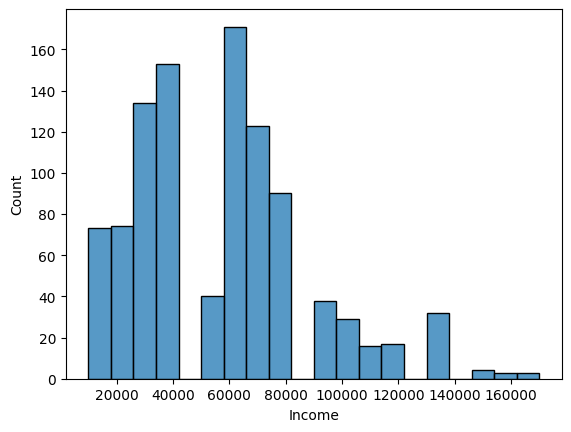

In [ ]:
sns.histplot(data = df, x='Income')

<Axes: xlabel='Children', ylabel='Count'>

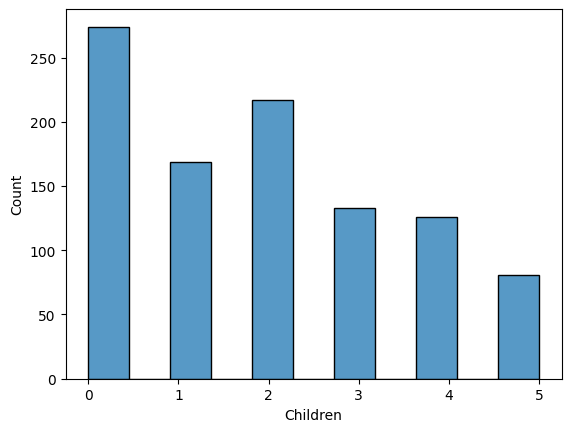

In [ ]:
sns.histplot(data = df, x='Children')

<Axes: xlabel='Cars', ylabel='Count'>

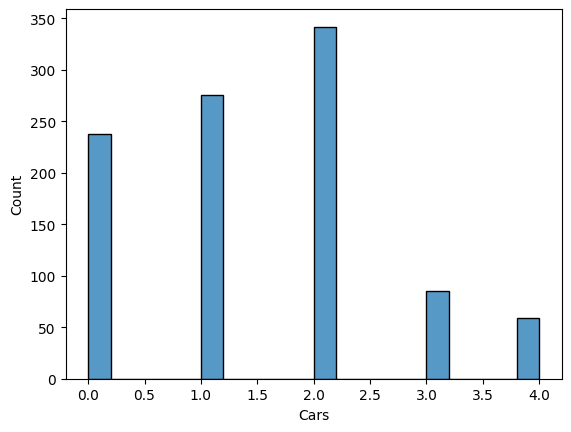

In [ ]:
sns.histplot(data = df, x='Cars')

<Axes: xlabel='Age', ylabel='Count'>

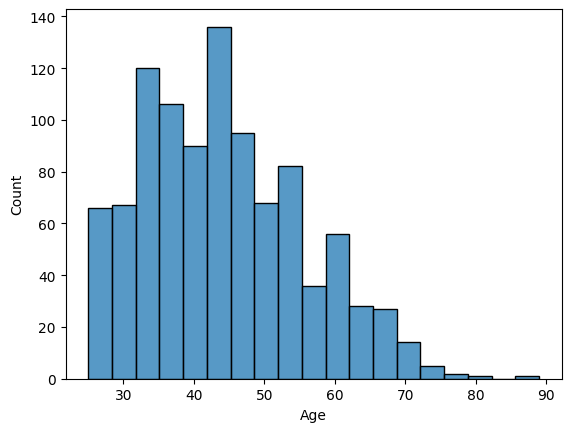

In [ ]:
sns.histplot(data = df, x='Age')

Аномальных выбросов нет.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df[X_categorical + X_numerical], y, test_size=0.25, random_state=777, stratify=y)

Пока использую сглаженный счетчик, если доделаю бонуски заменю на лучший.

In [ ]:
from sklearn.preprocessing import StandardScaler
max_c = 0
maxt = 0
for c in C:
  column_transformer = ColumnTransformer([
    ('mean', MeanSmoothEncoder(X_categorical, c), X_categorical),
    ('scaling', StandardScaler(), X_numerical)
  ])

  pipeline = Pipeline(steps=[
      ('mean', column_transformer),
      ('regression', LogisticRegression())
  ])

  pipeline.fit(X_train, y_train)
  t = average_precision_score(y_test, pipeline.predict_proba(X_test)[:, 1])
  if maxt < t:
    maxt = t
    max_c = c

column_transformer = ColumnTransformer([
    ('mean', MeanSmoothEncoder(X_categorical, max_c), X_categorical)
  ])

pipeline = Pipeline(steps=[
      ('mean', column_transformer),
      ('regression', LogisticRegression())
  ])

pipeline.fit(X_train, y_train)
print('Best C: {}'.format(max_c))
print(average_precision_score(y_test, pipeline.predict_proba(X_test)[:, 1]))

Best C: 2.9763514416313175
0.6677227920362265


 Сейчас для числовых признаков мы ищем линейную зависимость, что в общем случае  может быть неверной гипотезой. Тем не менее, у этих признаков есть довольно много уникальных значений (сколько?), поэтому применять к ним one-hot кодирование может оказаться излишним. Попробуйте закодировать эти признаки с помощью счетчиков. Стало ли лучше?

In [ ]:
amount = 0
for i in X_numerical:
  amount += len(df[i].unique())
print(amount)

80


Понадобится добавить 80 признаков при ohe.

In [ ]:
max_c = 0
maxt = 0
for c in C:
  column_transformer = ColumnTransformer([
    ('mean', MeanSmoothEncoder(X_categorical + X_numerical, c), X_categorical + X_numerical)
  ])

  pipeline = Pipeline(steps=[
      ('mean', column_transformer),
      ('regression', LogisticRegression())
  ])

  pipeline.fit(X_train, y_train)
  t = average_precision_score(y_test, pipeline.predict_proba(X_test)[:, 1])
  if maxt < t:
    maxt = t
    max_c = c

column_transformer = ColumnTransformer([
    ('mean', MeanSmoothEncoder(X_categorical + X_numerical, max_c), X_categorical + X_numerical)
  ])

pipeline = Pipeline(steps=[
      ('mean', column_transformer),
      ('regression', LogisticRegression())
  ])

pipeline.fit(X_train, y_train)
print('Best C: {}'.format(max_c))
print(average_precision_score(y_test, pipeline.predict_proba(X_test)[:, 1]))

Best C: 88.58667904100822
0.713489575125243


Качество существенно выросло.

> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).



Как мы могли пронаблюдать, счётчики являются конкурентной альтернативой one-hot-кодированию. Опишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__

Плюсы:
- Скорость вычислений из-за малого числа признаков
- Чуть лучшая понятность данных после трансформирования
- Качество бывает лучше

Минусы:
- Не замечено, но есть подозрение, что на более сложной выборке будет огромное переобучение в силу чего ухудшение на тестовых данных.

# Часть 3. Отбор признаков (2 балла)

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет.

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

--2024-12-02 16:33:45--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘adult.data’

adult.data              [ <=>                ]   3.79M  --.-KB/s    in 0.09s   

2024-12-02 16:33:45 (39.9 MB/s) - ‘adult.data’ saved [3974305]



In [ ]:
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
    'income'
]

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')
df.sample()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
1651,36,Self-emp-not-inc,136028,9th,5,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,30,United-States,0


Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.



Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify=True`.

In [ ]:
X = df.drop(columns=['income'])
y = df['income']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

Давайте закодируем все категориальные признаки с помощью One-hot Encoding. Сколько новых признаков мы получим?

In [ ]:
categorical = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
numerical = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

In [ ]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical)
  ])
X = column_transformer.fit_transform(X)
X.shape[1] - len(categorical)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [ ]:
model = LogisticRegression()
model.fit(X_train, y_train)
print(average_precision_score(y_test, model.predict_proba(X_test)[:, 1]))

0.685400992598871


Допустим, мы хотим оставить только 40 лучших признаков.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, одну из которых, используйте для валидации. Исходную тестовую выборку стоит использовать только для финальной оценки качества после процедуры фильтрации

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=777, stratify=y_train)

Попробуем сделать это следующими способами:

#### __Задание 9. Встроенные методы (0.5 балла)__

Начнём с отбора признаков с помощью модели. У разных алгоритмов есть разные встроенные способы оценки вклада признаков в предсказание. Как известно, у линейной модели за это отвечают веса, а значит, их модуль можно интерпретировать как важность. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.



In [ ]:
from sklearn.feature_selection import SelectFromModel
model = LogisticRegression()

In [ ]:
%%time
model.fit(X_train, y_train)
ind = np.argpartition(np.abs(model.coef_)[0], -40)[-40:]

CPU times: user 97.6 ms, sys: 1.3 ms, total: 98.9 ms
Wall time: 200 ms


In [ ]:
x_tr = X_train[:,ind]
x_va = X_valid[:,ind]
x_te = X_test[:,ind]
model.fit(x_tr, y_train)

LogisticRegression()

In [ ]:
print(average_precision_score(y_test, model.predict_proba(x_te)[:, 1]))

0.6417374509429576


Изменилось ли качество? Как?

Ухудшилось.

Подумаем, что мы не учли. Мы действовали в предположении, что признаки вносят вклад равномерно, и не учитывали их масштаб. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки.

Помните, что не все способы одинаково хороши, особенно в условиях наличия выбросов

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [ ]:
X = df.drop(columns=['income'])
y = df['income']

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical),
    ('scale', StandardScaler(), numerical)
  ])

X = column_transformer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=777, stratify=y_train)

In [ ]:
model = LogisticRegression()
model.fit(X_train, y_train)
print(average_precision_score(y_test, model.predict_proba(X_test)[:, 1]))

0.7664602418831096


In [ ]:
ind = np.argpartition(np.abs(model.coef_)[0], -40)[-40:]
x_tr = X_train[:,ind]
x_va = X_valid[:,ind]
x_te = X_test[:,ind]
model.fit(x_tr, y_train)
print(average_precision_score(y_test, model.predict_proba(x_te)[:, 1]))
print("Индексы признаков: ")
print(*ind)

0.7313507088734766
Индексы признаков: 
31 85 70 83 16 12 42 53 43 45 41 40 71 37 82 61 84 49 36 50 52 30 90 29 28 93 27 66 96 26 25 22 65 64 1 8 104 105 62 58


Качество вновь ниже, в сравнении с версией без отсеивания. Но выросло по сравнению с моделями без скейлинга.

Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [ ]:
X = df.drop(columns=['income'])
y = df['income']

X = StandardScaler(with_mean=False).fit_transform(column_transformer.fit_transform(X))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=777, stratify=y_train)

In [ ]:
model = LogisticRegression()
model.fit(X_train, y_train)
ind = np.argpartition(np.abs(model.coef_)[0], -40)[-40:]
x_tr = X_train[:,ind]
x_va = X_valid[:,ind]
x_te = X_test[:,ind]
model.fit(x_tr, y_train)
print(average_precision_score(y_test, model.predict_proba(x_te)[:, 1]))
print("Индексы признаков: ")
print(*ind)

0.7594545070719183
Индексы признаков: 
93 23 0 64 60 58 57 55 52 50 49 48 47 41 40 38 37 36 86 32 88 31 30 29 28 27 25 22 21 20 19 99 10 8 102 6 104 105 106 107


Качество выросло. Признаки изменились.

#### __Задание 10. Методы фильтрации (0.5 балла)__


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods.

Одна из самых простых функция - корреляция между признаком и целевой переменной. Подумайте, какая взаимосвязь между корреляцией и предсказательной способностью модели, и как бы вы использовали информацию о корреляции для отбора признаков

**Ответ:** Хорошая корреляция или антикорреляция указывает на то, что как правило изменение признака соотвествует изменению таргета. Если корреляция близка к 0, это говорит, что признак и таргет скорее всего не связаны никак. Я бы брал корреляцию по модулю и отбирал признаки с наибольшим модулем.

Посчитайте корреляцию каждого признака с таргетом и отфильтруйте 40 признаков исходя из того, что вы описали, после чего замерьте качество и время отбора



In [ ]:
X = df.drop(columns=['income'])
y = df['income']

X = column_transformer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=777, stratify=y_train)

In [ ]:
%%time
corrs = []
for i in range(X_train.shape[1]):
  corrs.append(np.corrcoef(X_train[:, i].toarray().reshape(y_train.shape), y_train)[1,0])
ind = np.argpartition(np.abs(corrs), -40)[-40:]

CPU times: user 133 ms, sys: 2.05 ms, total: 135 ms
Wall time: 140 ms


In [ ]:
x_tr = X_train[:,ind]
x_va = X_valid[:,ind]
x_te = X_test[:,ind]
model.fit(x_tr, y_train)
print(average_precision_score(y_test, model.predict_proba(x_te)[:, 1]))
print("Индексы признаков: ")
print(*ind)

0.7614104487625688
Индексы признаков: 
31 86 39 9 1 24 0 59 58 57 55 52 51 50 49 48 47 42 40 38 36 33 32 30 29 27 25 23 21 20 19 18 10 5 102 4 104 105 106 107


В качестве еще одной функция можно считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставьте 40 признаков с наибольшим значением $t$, замерьте качество и скорость отбора признаков.

In [ ]:
X = df.drop(columns=['income'])
y = df['income']

X = column_transformer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=777, stratify=y_train)

In [ ]:
(X_train[:, 0].toarray().reshape(y_train.shape) == 0).sum()

17285

In [ ]:
%%time
t = []
for i in range(X_train.shape[1] - 6): #Числовые признаки возьмем по умолчанию, так как я не знаю, как считать t-stat для них
  nup = y_train[X_train[:, i].toarray().reshape(y_train.shape) == 1].mean()
  num = y_train[X_train[:, i].toarray().reshape(y_train.shape) == 0].mean()
  sp = y_train[X_train[:, i].toarray().reshape(y_train.shape) == 1].var()
  sm = y_train[X_train[:, i].toarray().reshape(y_train.shape) == 0].var()
  npo = (X_train[:, i].toarray().reshape(y_train.shape) == 1).sum()
  nm = (X_train[:, i].toarray().reshape(y_train.shape) == 0).sum()
  t.append(np.abs(nup - num)/np.sqrt((npo*sp + nm*sm)/(npo+nm)))
ind = np.argpartition(t, -40)[-40:]
ind = np.concatenate([ind,[102, 103, 104, 105, 106, 107]])

CPU times: user 552 ms, sys: 1.5 ms, total: 553 ms
Wall time: 557 ms


In [ ]:
x_tr = X_train[:,ind]
x_va = X_valid[:,ind]
x_te = X_test[:,ind]
model.fit(x_tr, y_train)
print(average_precision_score(y_test, model.predict_proba(x_te)[:, 1]))
print("Индексы признаков: ")
print(*ind)

0.7539427113282122
Индексы признаков: 
74 93 48 15 13 30 79 87 92 66 26 73 64 10 34 3 22 59 58 12 40 41 18 42 86 52 88 51 49 8 50 19 21 23 75 27 29 5 36 47 102 103 104 105 106 107


#### __Задание 11. Методы-обёртки__ (1 балл)

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем признаки по очереди и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, алгоритм выглядит так:

- $k$ - число признаков, которых мы хотим оставить
- $m$ - число признаков, которых мы выбрасываем на каждой итерации, оно же длина шага

Шаг $i$:
- $F_i$ - набор признаков (равный всему множеству признаков на i=0)
- $M_i$ - их число, в общем случае $\max(k, M_{i-1} - m)$
1. Если признаков осталось ровно $k$, либо метрика стала уменьшаться более, чем на $\epsilon$ — останавливаемся (не наш случай, но так тоже можно)
2. Обучаем модель $a_i$ на наборе $F_i$, после чего оцениваем важность признаков (любым из способов выше или какими-нибудь ещё)
3. Отбираем $\min(M_i - k, m)$ наиболее бесполезных, согласно пункту 2, признаков (берем $m$, если можем, иначе оставляем вплоть до k), удаляем, переходим к следующему шагу

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Подберите длину шага из каких-то соображений (каких, кстати?) и замерьте время работы метода

Соображения таковы, что чем меньше длина шага, тем будет лучше качество, на это может навести просто принцип жадных алгоритмов. А чем больше будет длина шага, тем быстрее будет алгоритм.

In [ ]:
X = df.drop(columns=['income'])
y = df['income']

X = column_transformer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=777, stratify=y_train)

In [ ]:
def wrap_method(X_tr, y_tr, m, k):
  M = X_tr.shape[1]
  F = set(np.arange(M))
  model = LogisticRegression()
  while M != k:
    x_tr = X_tr[:,np.array(list(F))]
    model.fit(x_tr, y_tr)
    drop = np.argpartition(model.coef_[0], min(M - k, m))[:min(M - k, m)]
    F = F - set(np.array(list(F))[drop].flatten())
    M = M - min(M - k, m)
  return np.array(list(F))

In [ ]:
%%time
ind = wrap_method(X_train, y_train, 5, 40)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

CPU times: user 2.22 s, sys: 9.7 ms, total: 2.23 s
Wall time: 2.23 s


In [ ]:
x_tr = X_train[:,ind]
x_va = X_valid[:,ind]
x_te = X_test[:,ind]
model.fit(x_tr, y_train)
print(average_precision_score(y_test, model.predict_proba(x_te)[:, 1]))
print("Индексы признаков: ")
print(*ind)

0.7551681706568009
Индексы признаков: 
0 1 12 13 19 25 26 27 31 33 35 36 38 39 42 43 44 45 46 47 48 51 52 59 61 62 65 70 71 74 82 84 90 96 98 99 102 104 105 107


Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ самые полезные признаки в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [ ]:
def reverse_wrap_method(X_tr, y_tr, m, k):
  M = 0
  F = set(np.arange(X_tr.shape[1]))
  model = LogisticRegression()
  while M != k:
    x_tr = X_tr[:,np.array(list(F))]
    model.fit(x_tr, y_tr)
    take = np.argpartition(model.coef_[0], -min(k-M, m))[-min(k-M, m):]
    F = F - set(np.array(list(F))[take].flatten())
    M = M + min(k-M, m)
  return np.array(list(set(np.arange(X_tr.shape[1])) - F))

In [ ]:
%%time
ind = reverse_wrap_method(X_train, y_train, 3, 40)
ind.shape

CPU times: user 1.67 s, sys: 8.8 ms, total: 1.68 s
Wall time: 1.68 s


(40,)

In [ ]:
x_tr = X_train[:,ind]
x_va = X_valid[:,ind]
x_te = X_test[:,ind]
model.fit(x_tr, y_train)
print(average_precision_score(y_test, model.predict_proba(x_te)[:, 1]))
print("Индексы признаков: ")
print(*ind)

0.7521945508389387
Индексы признаков: 
1 3 5 19 21 23 26 27 36 43 52 54 55 57 59 61 62 65 70 71 74 75 76 78 80 81 82 84 90 96 97 98 99 101 102 103 104 105 106 107


In [ ]:
nu = np.arange(5, 100)
mu = []
for i in nu:
  ind = reverse_wrap_method(X_train, y_train, 5, i)
  x_tr = X_train[:,ind]
  x_te = X_test[:,ind]
  model.fit(x_tr, y_train)
  mu.append(average_precision_score(y_test, model.predict_proba(x_te)[:, 1]))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Text(0.5, 1.0, 'Зависимость качества от количества выбранных признаков')

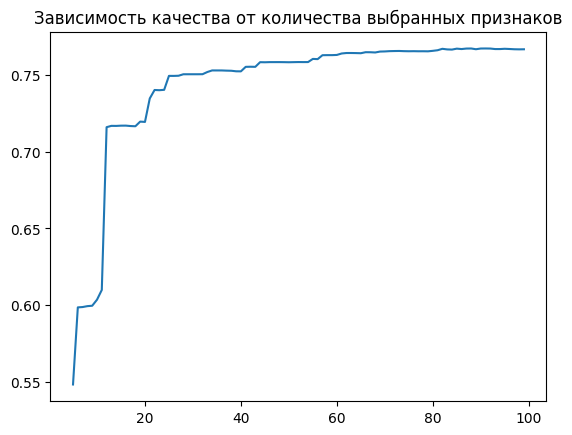

In [ ]:
plt.plot(nu, mu)
plt.title('Зависимость качества от количества выбранных признаков')

Такого порога не нашлось

Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:**
- Лучший по качеству - отбор по корреляции
- Отбор по размеру веса - быстрый, некачественный
- Отбор по t-статистике - нужно писать самому, не стоит того
- Отбор оберткой - медленно, потенциально может быть лучшим, если использовать другой отбор внутри.

# Часть 4. Оценка экономического эффекта модели (2 балла)



В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно:
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

--2024-12-02 18:01:04--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘bank-additional.zip’

bank-additional.zip     [ <=>                ] 434.15K  --.-KB/s    in 0.04s   

2024-12-02 18:01:04 (10.8 MB/s) - ‘bank-additional.zip’ saved [444572]

Archive:  bank-additional.zip
   creating: bank-additional/
  inflating: bank-additional/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/bank-additional/
  inflating: __MACOSX/bank-additional/._.DS_Store  
  inflating: bank-additional/.Rhistory  
  inflating: bank-additional/bank-additional-full.csv  
  inflating: bank-additional/bank-additional-names.txt  
  inflating: bank-additional/bank-additional.csv  
  inflating: __MACOSX/._bank-additional  


In [ ]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [ ]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте наиболее подходящие с вашей точки зрения параметры и их значения (`shuffle`, `stratify`, число фолдов, ...). По кросс-валидации у вас получится несколько вариантов обучающей и тестовой выборки. Для удобства можно воспользоваться шаблоном ниже, который по ходу выполнения задания будет обрастать функционалом. Как обычно, это необязательно, но сохранять результаты экспериментов очень и очень желательно, в конце мы будем их сравнивать

In [ ]:
from collections import defaultdict
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

def profit(y_test, y_predict):
  return np.sum(y_test & y_predict)*10 - np.sum(y_predict)*2
def rand_profit(y_test, y_predict):
  return np.sum((y_test & y_predict)*np.random.uniform(low = 0, high = 20, size = y_test.shape)) - np.sum(y_predict)*2

def cross_validate(
    X,
    y,
    n_splits=5,
    random_state=None,
    shuffle=False,
    stratify=False,
    l2_coef = np.inf,
    bin_threshold = None
):
    metrics = []
    # или любой другой фолд, посмотрите в model_selection
    if stratify:
      kf = StratifiedKFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)
    else:
      kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)

    for train_index, test_index in kf.split(X, y):

        # возьмите датасет и обучите модель
        model = LogisticRegression(penalty='l2', C = l2_coef)
        model.fit(X[train_index, :], y[train_index])
        probs = model.predict_proba(X[test_index])[:, 1]
        if bin_threshold == None:
          predict = model.predict(X[test_index])
        else:
          predict = (model.predict_proba(X[test_index])[:, 1] > bin_threshold)

        # посчитайте метрики, которые вам нужны и добавьте результаты с каждого фолда
        metric_dict = {
            "AUC-ROC": roc_auc_score(y[test_index], probs),
            "AUC-PR": average_precision_score(y[test_index], probs),
            "Precision": precision_score(y[test_index], predict, zero_division=0),
            "Recall": recall_score(y[test_index], predict),
            "profit": profit(y[test_index], predict),
            "rand_profit": rand_profit(y[test_index], predict),
            "TC": np.sum(predict)*2
        }
        metrics.append(metric_dict)

    # осталось только красиво всё обернуть
    return pd.DataFrame(metrics)

Выберите метрику классификации, которая вам кажется подходящей, и обучите логистическую регрессию на каждой обучающей выборке (закодируйте категориальные признаки способом, который выше вам понравился больше всех, отнормируйте числовые, гиперпараметры оставьте по умолчанию), сделайте предсказания для соответствующих тестовых выборок, выведите результаты

<Axes: xlabel='previous', ylabel='Count'>

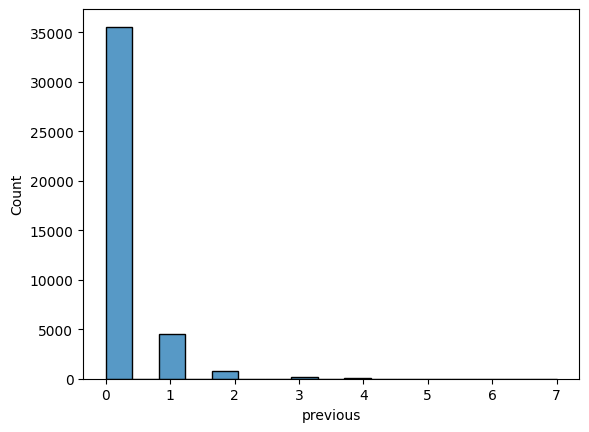

In [ ]:
sns.histplot(df['previous']) # Хоть и числовой, но тренд явно не линейный лучше в категориальные

<Axes: xlabel='pdays', ylabel='Count'>

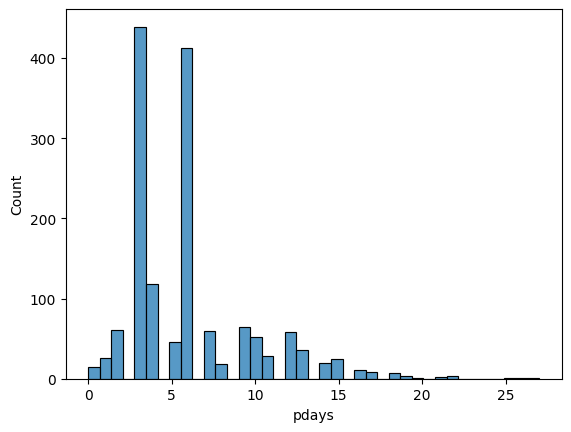

In [ ]:
sns.histplot(df[df['pdays'] < 50]['pdays']) # Лучше было бы через дамми признаки разбить на несколько, но пока оставим как есть

In [ ]:
numerical = ['age', 'campaign', 'pdays', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
categorical = list(df.select_dtypes(include='object').columns.drop('y')) + ['previous']

Использовать буду AUC-PR и Precision, так как малое число клиентов соглашается на звонок. Однако вынесу в таблицу и AUC-ROC для дополнительных рассуждений.

In [ ]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical),
    ('scale', StandardScaler(), numerical)
  ])

In [ ]:
cross_validate(column_transformer.fit_transform(X), y, random_state=1337, shuffle=True)

,AUC-ROC,AUC-PR,Precision,Recall,profit,rand_profit,TC
0,0.796240,0.438982,0.624615,0.225055,1380,1396.211077,650
1,0.785588,0.426322,0.609971,0.228321,1398,1422.878813,682
2,0.776087,0.443800,0.660494,0.225738,1492,1475.838885,648
3,0.791601,0.470342,0.668770,0.225053,1486,1525.021957,634
4,0.805078,0.481916,0.732673,0.236926,1614,1672.759314,606


Допустим, работники вашего колл-центра получают за один звонок клиенту 2 доллара. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить.

В качестве бизнес-метрики в нашей задаче мы будем считать прибыль aka `profit`, соответственно лучшую модель будем выбирать исходя из этого.
Посчитайте на всех тестовых выборках выручку и сохраните результаты для бизнес-метрики вместе с предыдущей метрикой, которую вы выбрали

Ответьте на вопросы:
- Сколько денег вы в среднем заработаете?
- Какое получилось стандартное отклонение профита?
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?
- Пропорциональна ли бизнес-метрика выбранной метрике классификации?

In [ ]:
res = cross_validate(column_transformer.fit_transform(X), y, random_state=1337, shuffle=True, stratify=True)
res['profit'].describe()

,profit
count,5.000000
mean,1478.400000
std,115.597578
min,1356.000000
25%,1368.000000
50%,1518.000000
75%,1520.000000
max,1630.000000


Средне денег: 1478.400000

std: 115.597578

In [ ]:
res['TC'].mean() #Средние траты на работников

639.6

<Axes: ylabel='profit'>

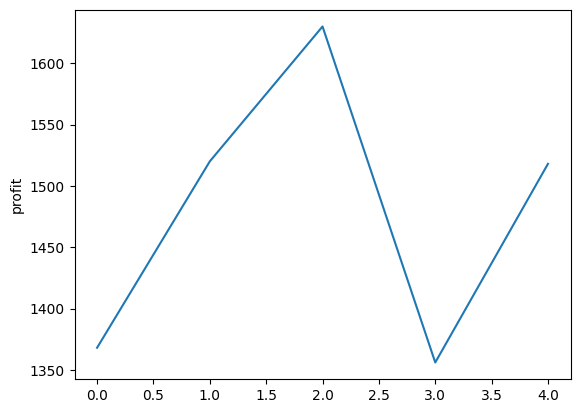

In [ ]:
sns.lineplot(res['profit'])

<Axes: >

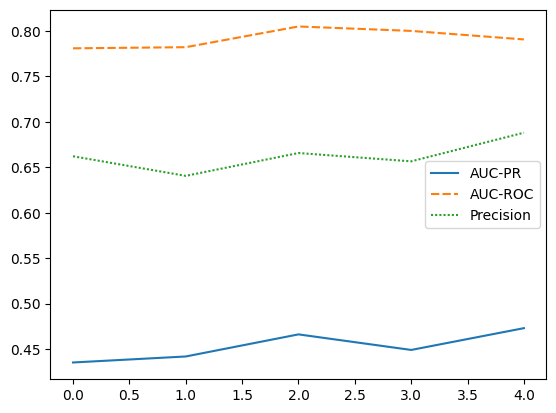

In [ ]:
sns.lineplot(res[['AUC-PR', 'AUC-ROC', 'Precision']])

Динамика повторяет AUC-PR

Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента (для разбиения на фолды разумеется оставьте). Что получилось?

In [ ]:
res = cross_validate(column_transformer.fit_transform(X), y, random_state=1337, shuffle=True, stratify=True)
res['rand_profit'].describe()

,rand_profit
count,5.000000
mean,1439.998130
std,128.801260
min,1290.301322
25%,1320.365060
50%,1469.451631
75%,1559.882431
max,1559.990205


Среднее: 1417

std: 127

In [ ]:
res['TC'].mean() #Средние траты на работников

639.6

<Axes: ylabel='rand_profit'>

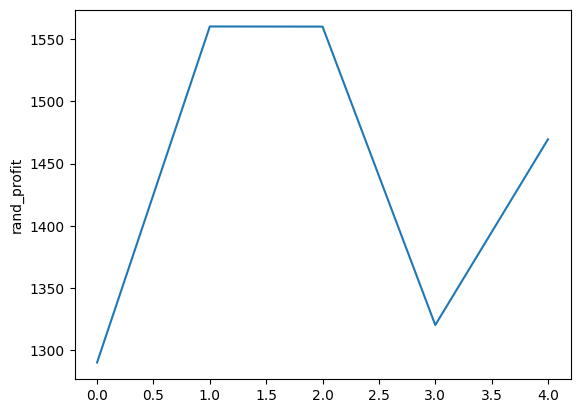

In [ ]:
sns.lineplot(res['rand_profit'])

<Axes: >

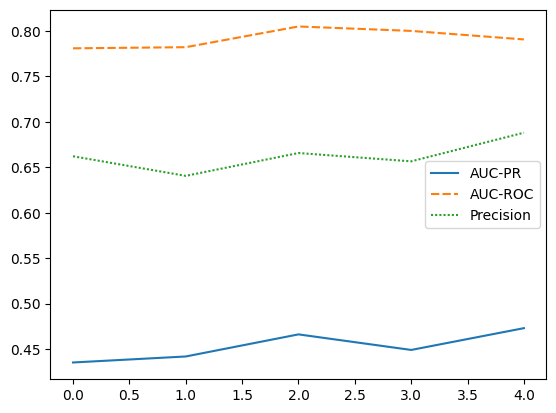

In [ ]:
sns.lineplot(res[['AUC-PR', 'AUC-ROC', 'Precision']])

Вновь совпадает с динамикой AUC-PR, и + с Precision

Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента

In [ ]:
C = np.logspace(-3, 4, 20)
prof = []
for c in C:
  res = cross_validate(column_transformer.fit_transform(X), y, l2_coef=c)
  prof.append(res['rand_profit'].mean())
print(C[np.argmax(prof)])

61.58482110660255


Text(0, 0.5, 'Прибыль')

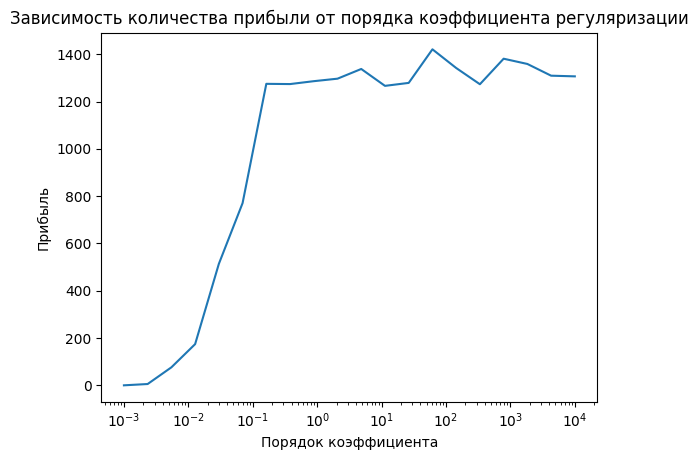

In [ ]:
plt.plot(C, prof)
plt.xscale('log')
plt.title('Зависимость количества прибыли от порядка коэффициента регуляризации')
plt.xlabel('Порядок коэффициента')
plt.ylabel('Прибыль')

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

Единственная закономерность, что они все больше единицы. Вывод - случайность прибыли сильно влияет на коэффициент регуляризации.

In [ ]:
C = np.logspace(-1, 6, 20)
for i in range(10):
  prof = []
  for c in C:
    res = cross_validate(column_transformer.fit_transform(X), y, l2_coef=c)
    prof.append(res['rand_profit'].mean())
  print(C[np.argmax(prof)])

206.9138081114788
88.58667904100822
33598.18286283781
2.9763514416313175
6158.482110660255
1.2742749857031335
206.9138081114788
37.926901907322495
428133.2398719387
6158.482110660255


#### __Задание 13. Ключевая метрика__ (1 балл)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ посчитаем прибыль в терминах TP, FP, TN, FN:
$$profit = TP*\nu - (TP+FP)*c$$
Где $\nu$ - сл. величина количества выручки за звонок, а c - оплата работы оператора. Тогда лучше всего его отражает $precision = \frac{TP}{TP+FP}$, они растут и убывают при одинаковых изменениях TP, FP (при фиксированных $\nu$). Recall может иметь другую динамику с прибылью.



> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот. Добавьте новую ML-метрику в ваш CV-пайплайн, найдите такой порог, при котором бизнес-метрика максимальна, и проверьте, связана ли новая ML метрика с профитом

Считаем, что добавил Precision.

In [ ]:
thr = np.linspace(0, 1, 100)
prof = []
prec = []
for t in thr:
  res = cross_validate(column_transformer.fit_transform(X), y, bin_threshold=t)
  prof.append(res['rand_profit'].mean())
  prec.append(res['Precision'].mean())

In [ ]:
best_prec_t = thr[np.argmax(prec)]
best_profit_t = thr[np.argmax(prof)]
np.max(prof)

2478.7523137399503

Text(0, 0.5, 'Profit')

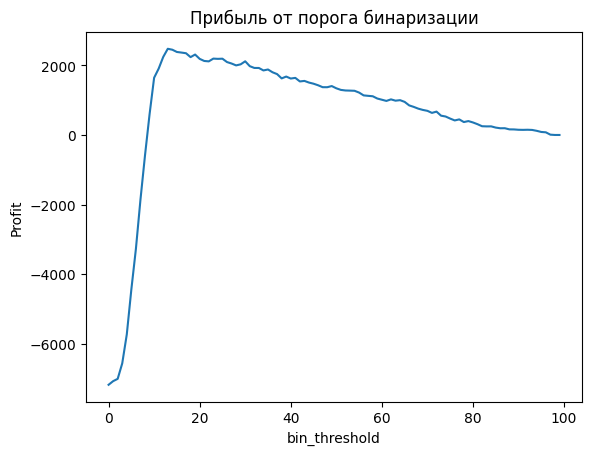

In [ ]:
sns.lineplot(prof)
plt.title('Прибыль от порога бинаризации')
plt.xlabel('bin_threshold')
plt.ylabel('Profit')

Text(0, 0.5, 'Precision')

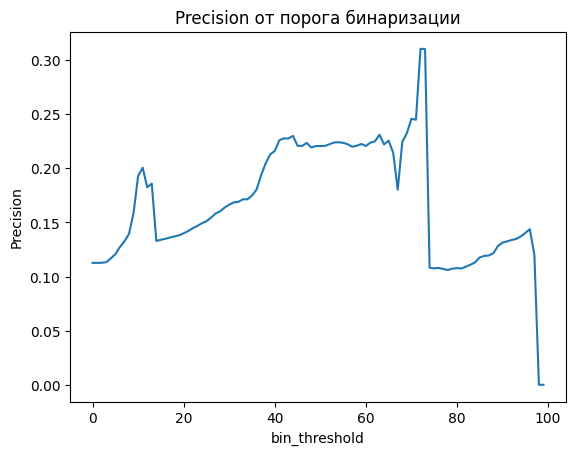

In [ ]:
sns.lineplot(prec)
plt.title('Precision от порога бинаризации')
plt.xlabel('bin_threshold')
plt.ylabel('Precision')

Постройте график зависимости прибыли от порога бинаризации. Выделите наилучший порог




In [ ]:
# График построен выше, лучший порог:
print(best_profit_t)

0.13131313131313133


__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

Выглядит так как будто бы, если очистить график от случайных выбросов, то он имеет форму, напоминающую параболу.

Text(0, 0.5, 'Profit')

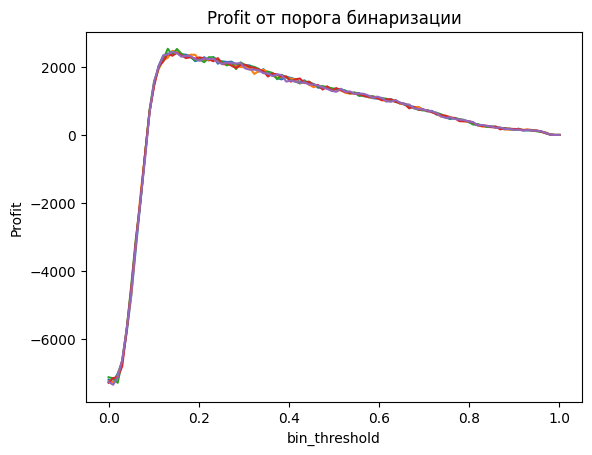

In [320]:
thr = np.linspace(0, 1, 100)
best = []
for i in range(5): # Это будет длится полчаса, пойду покурю
  prof = []
  for t in thr:
    res = cross_validate(column_transformer.fit_transform(X), y, bin_threshold=t)
    prof.append(res['rand_profit'].mean())
  plt.plot(thr, prof, label = thr[np.argmax(prof)])
plt.title('Profit от порога бинаризации')
plt.xlabel('bin_threshold')
plt.ylabel('Profit')

__Ответ:__ Да, он получается в конкретной области. Вероятно, это тот интервал при, котором ожидание прибыли максимально.

Наконец, чтобы точнее понять, что наша модель лучше исходной, посчитайте среднее и стандартное отклонение по фолдам бизнес-метрики для оптимизированной модели (гиперпараметры + порог) и дефолтной логистической регрессии. Проверьте, действительно ли удалось добиться значимого изменения прибыли — примените какой-либо статистический тест (например, парный t-критерий с $\alpha=0.95$) к метрике, полученной двумя этими моделями

In [321]:
thr = np.linspace(0, 1, 10)
C = np.logspace(-1, 6, 10)
maxprof = 0
best_t = 0
best_c = 0
for t in thr:
  for c in C:
    res = cross_validate(column_transformer.fit_transform(X), y, random_state=1337, shuffle=True, bin_threshold=t, l2_coef=c)
    if res['rand_profit'].mean() > maxprof:
      maxprof = res['rand_profit'].mean()
      best_t = t
      best_c = c

In [324]:
res = cross_validate(column_transformer.fit_transform(X), y, random_state=1337, shuffle=True, bin_threshold=best_t, l2_coef=best_c)
res['rand_profit'].describe()

,rand_profit
count,5.000000
mean,2733.684885
std,265.313941
min,2434.055241
25%,2626.276777
50%,2651.888642
75%,2813.661074
max,3142.542692


In [325]:
res_default = cross_validate(column_transformer.fit_transform(X), y, random_state=1337, shuffle=True)
res_default['rand_profit'].describe()

,rand_profit
count,5.000000
mean,1470.700222
std,79.302187
min,1356.881350
25%,1439.996825
50%,1465.372649
75%,1544.614416
max,1546.635867


In [326]:
from scipy import stats
stats.ttest_rel(res['rand_profit'], res_default['rand_profit'])

TtestResult(statistic=14.248943106377281, pvalue=0.00014089425362791278, df=4)

Принимаем гипотезу о значимом изменении, в силу $pvalue<0.05$

# __Бонусная часть. Многоклассовая классификация__ (1.5 балла)

Как известно, некоторые задачи не ограничиваются всего лишь двумя классами. На лекции вы проходили несколько способов обобщения линейных моделей на этот случай: One-vs-Rest и One-vs-One. Ниже мы посмотрим, в чём преимущества и недостатки обоих подходов, а так же попробуем ещё один чуть более экзотический метод

#### **Задание 14. One-vs-Rest vs One-vs-One** (0.5 балла)

В качестве [датасета](https://www.kaggle.com/datasets/thedevastator/higher-education-predictors-of-student-retention/data) здесь и ниже мы будем брать очень жизненные и актуальные данные о том, доучится студент или нет, в зависимости от курсов, возраста, гендера и прочих (не)осуждаемых признаков.

In [353]:
import kagglehub

path = kagglehub.dataset_download("thedevastator/higher-education-predictors-of-student-retention") + "/dataset.csv"

features = ["Marital status", "Course", "Nacionality", "Gender", "Age at enrollment"]
target = "Target"

100%|██████████| 87.2k/87.2k [00:00<00:00, 40.1MB/s]

Extracting files...


Будем смотреть только какое-то подмножество наиболее весёлых факторов. От вас по классике потребуется их преобразовать, в зависимости от того, числовые они или категориальные и **закодировать таргет чиселками!!!**

In [355]:
df = pd.read_csv(path)

In [366]:
numerical = ["Course", "Age at enrollment"]
categorical = ["Nacionality", "Marital status", "Gender"]
df[target] = pd.factorize(df[target])[0] + 1

In [367]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical),
    ('scale', StandardScaler(), numerical)
  ])

In [369]:
X = df[features]
y = df[target]
X = column_transformer.fit_transform(X)

In [370]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=228, shuffle=True, test_size=0.2)

Ваш следующий шаг - посмотреть, каким образом в `sklearn` реализованы OvR и OvO, обучить таким образом логистическую регрессию с `max_iter=10000`, далее выбрать какую-то метрику (и её усреднение, его выбор тоже аргументируйте), и сравнить следующие параметры:
- число классификаторов
- скорость обучения
- качество модели

Также сохраните куда-нибудь предсказания вероятностей у каждой из моделей. Это можно сделать не одним способом, но возможно вам чуть с этим поможет следующий пункт


In [375]:
%%time
from sklearn.multiclass import OneVsRestClassifier
clf = OneVsRestClassifier(LogisticRegression(max_iter=10000)).fit(X_train, y_train)
average_precision_score(y_test, clf.predict_proba(X_test)[:, 1])

ValueError: Expected 2D array, got 1D array instead:
array=[0.42182491 0.39976482 0.2972601  0.62721779 0.37523754 0.60170665
 0.40951791 0.31319512 0.62721779 0.40757352 0.60892659 0.61593661
 0.61814905 0.52876938 0.60357801 0.44112875 0.38410176 0.37331
 0.61719826 0.18911349 0.52740461 0.5571188  0.61657957 0.62360079
 0.50050426 0.41146148 0.628755   0.60518617 0.24592634 0.62460433
 0.59553952 0.59226947 0.48460652 0.68777027 0.61436072 0.60518617
 0.38410176 0.40464405 0.43264298 0.6307842  0.40659922 0.47079871
 0.34590716 0.62669501 0.17333073 0.48732304 0.6111883  0.39976482
 0.63323225 0.55414156 0.49995142 0.59239801 0.57709177 0.25600913
 0.62033123 0.62460433 0.33900134 0.48460652 0.62567373 0.39876554
 0.19511339 0.40757352 0.39876554 0.49677322 0.39876554 0.54104421
 0.2701668  0.39976482 0.64412272 0.60984566 0.19300067 0.6307842
 0.60983293 0.3507402  0.61436072 0.40951791 0.42014862 0.58212351
 0.5571188  0.61876819 0.39782037 0.40951791 0.30435267 0.35957926
 0.40757352 0.60823741 0.61876819 0.52740461 0.61436072 0.61657957
 0.62460433 0.62460433 0.62305418 0.628755   0.62460433 0.19090676
 0.62092643 0.42497541 0.61657957 0.21797005 0.27897947 0.6307842
 0.49999353 0.41340987 0.61436072 0.40757352 0.43353718 0.61876819
 0.40659922 0.3011738  0.1867753  0.42014862 0.30870014 0.63517524
 0.34590716 0.62460433 0.61158837 0.63278255 0.49816407 0.42497541
 0.61876819 0.36932059 0.17502091 0.61436072 0.42577556 0.61211179
 0.4475469  0.38205444 0.279957   0.40757352 0.61436072 0.17374797
 0.34772151 0.53752087 0.43548458 0.41826273 0.60663501 0.20232492
 0.62460433 0.60752433 0.61936295 0.5396912  0.61436072 0.40462319
 0.43810173 0.38205444 0.61719826 0.61814905 0.37227941 0.38205444
 0.61876819 0.41340987 0.40075318 0.60823741 0.31685151 0.61877968
 0.17775374 0.63859205 0.41340987 0.39876554 0.39581771 0.628755
 0.61436072 0.628755   0.26995155 0.54099627 0.63668651 0.6307842
 0.39782037 0.37007628 0.61876819 0.63668651 0.62721779 0.44671714
 0.62460433 0.61936295 0.6307842  0.24181947 0.33680568 0.61436072
 0.38705112 0.54104421 0.29269488 0.42014862 0.63278255 0.26751103
 0.62925348 0.61719826 0.63517524 0.39286498 0.5914206  0.21042795
 0.57877571 0.60357801 0.58045296 0.42504338 0.41436632 0.4211598
 0.52352339 0.62460433 0.62460433 0.60752433 0.61814905 0.4056274
 0.42497541 0.39193822 0.62460433 0.61936295 0.62460433 0.33736997
 0.62460433 0.63668651 0.61436072 0.29527791 0.56815102 0.38410176
 0.61814905 0.38603806 0.22332264 0.61436072 0.6307842  0.62669501
 0.48780353 0.61593661 0.60592247 0.61814905 0.38410176 0.60983293
 0.4056274  0.5914206  0.61876819 0.41921209 0.40951791 0.59880136
 0.62721779 0.61436072 0.51134756 0.61593661 0.26318381 0.61436072
 0.61277795 0.39488185 0.62460433 0.41826273 0.63668651 0.35453651
 0.62460433 0.63859205 0.62033123 0.60752433 0.61936295 0.53752087
 0.35957926 0.60663501 0.60518617 0.6307842  0.5396912  0.61436072
 0.41340987 0.61436072 0.34969228 0.28169621 0.40421035 0.15574432
 0.61593661 0.62925348 0.62460433 0.60518617 0.38705112 0.41826273
 0.37124055 0.42978912 0.62721779 0.61876819 0.2156636  0.58212351
 0.40464405 0.63668651 0.17372166 0.40075318 0.6307842  0.36636166
 0.36548012 0.61436072 0.61436072 0.51275021 0.61657957 0.62925348
 0.62033123 0.20672674 0.61341997 0.61436072 0.60752433 0.55790547
 0.61814905 0.51469955 0.61814905 0.38603806 0.61436072 0.57625763
 0.63668651 0.42209891 0.59717385 0.60663501 0.22873457 0.63859205
 0.61814905 0.61593661 0.52216958 0.59226947 0.60983293 0.33607858
 0.60663501 0.41826273 0.61436072 0.36444546 0.63278255 0.61814905
 0.51469955 0.25391138 0.49175569 0.51469955 0.41049566 0.42692359
 0.63278255 0.60357801 0.28244976 0.61593661 0.40659922 0.40464405
 0.64231015 0.60823741 0.46987009 0.42014862 0.38105213 0.60752433
 0.26458023 0.37819437 0.61657957 0.30569464 0.60663501 0.43264298
 0.59226947 0.54220416 0.61876819 0.62925348 0.59473594 0.63005739
 0.61593661 0.60752433 0.60274432 0.63278255 0.59390928 0.39984895
 0.61436072 0.61876819 0.60357801 0.44671714 0.60752433 0.20519304
 0.6111883  0.62721779 0.36740042 0.19228259 0.62460433 0.61876819
 0.40464405 0.180214   0.63278255 0.23386296 0.60823741 0.31167634
 0.60518617 0.41340987 0.63517524 0.628755   0.28244976 0.41244118
 0.35533425 0.62721779 0.38499806 0.60752433 0.54104421 0.36444546
 0.6111883  0.41156534 0.62460433 0.59717385 0.62033123 0.2665604
 0.44838589 0.62033123 0.62925348 0.61876819 0.64539393 0.39092808
 0.62721779 0.61436072 0.61719826 0.1924076  0.48756241 0.62925348
 0.39293815 0.60983293 0.62567373 0.39876554 0.62460433 0.60357801
 0.61876819 0.59717385 0.57351586 0.20299435 0.63668651 0.42978912
 0.61876819 0.42978912 0.60752433 0.69890985 0.59636963 0.40367966
 0.41340987 0.54104421 0.62721779 0.26751103 0.56988849 0.59958295
 0.3719588  0.57182043 0.64412272 0.628755   0.62092643 0.41340987
 0.38205444 0.34590716 0.61719826 0.63125831 0.6307842  0.36827776
 0.61052263 0.41436632 0.30749814 0.60357801 0.35853815 0.35561615
 0.61436072 0.49995142 0.59636963 0.46383308 0.39581771 0.61277795
 0.63668651 0.62669501 0.628755   0.31005499 0.55865222 0.279957
 0.64412272 0.61593661 0.23443927 0.3189223  0.38603806 0.39581771
 0.37035546 0.62460433 0.37124055 0.58212351 0.6111883  0.41436632
 0.62460433 0.61436072 0.61876819 0.28892947 0.31034521 0.61814905
 0.28793147 0.33649099 0.62925348 0.37124055 0.62460433 0.340878
 0.58212351 0.61436072 0.43831336 0.61657957 0.61436072 0.49914023
 0.14168239 0.60357801 0.38501541 0.40951791 0.62092643 0.72342272
 0.35080029 0.43264298 0.61593661 0.3054101  0.39092808 0.39581771
 0.45964282 0.62925348 0.42514332 0.33607858 0.47707322 0.42497541
 0.59062285 0.40951791 0.63668651 0.61052263 0.37420304 0.28442647
 0.62925348 0.37909119 0.61343041 0.63668651 0.39581771 0.24431427
 0.39488185 0.60752433 0.61052263 0.51236861 0.55472613 0.57182043
 0.62567373 0.60892659 0.61719826 0.40951791 0.58212351 0.59636963
 0.61876819 0.39193822 0.61436072 0.5536565  0.3566307  0.73546484
 0.37662069 0.57955218 0.53280144 0.39642387 0.60357801 0.64412272
 0.64412272 0.43353718 0.36252926 0.63517524 0.59880136 0.24270648
 0.62721779 0.38012473 0.60752433 0.61719826 0.29269488 0.38501541
 0.39581771 0.60518617 0.61876819 0.59717385 0.41826273 0.29310927
 0.62460433 0.43264298 0.156357   0.43353718 0.39594774 0.61593661
 0.60592247 0.14659507 0.38501541 0.55472613 0.52862704 0.33129791
 0.62460433 0.29523838 0.52862704 0.59473594 0.5889694  0.60983293
 0.62248303 0.39876554 0.64412272 0.62567373 0.41826273 0.60752433
 0.67461732 0.61436072 0.60983293 0.37624773 0.39488185 0.63125831
 0.30083666 0.60663501 0.62721779 0.41244118 0.34674994 0.60983293
 0.25538296 0.25870198 0.60663501 0.39293815 0.60592247 0.61436072
 0.61052263 0.61436072 0.32260651 0.6307842  0.60823741 0.41631554
 0.39976482 0.43842804 0.63668651 0.55056132 0.42453637 0.61657957
 0.60983293 0.42209891 0.54972006 0.60663501 0.61814905 0.57709177
 0.5581909  0.55430015 0.10666771 0.39782037 0.56644442 0.61436072
 0.42404695 0.38603806 0.28617749 0.62033123 0.61657957 0.55539085
 0.43264298 0.36252926 0.62460433 0.48277187 0.62721779 0.6307842
 0.20102478 0.5054104  0.44671714 0.62033123 0.61814905 0.58812201
 0.36629527 0.29589099 0.37227941 0.61593661 0.34969228 0.62460433
 0.62460433 0.59226947 0.27518354 0.62460433 0.496815   0.62033123
 0.55430015 0.60592247 0.4056274  0.40530523 0.61657957 0.60663501
 0.37124055 0.64412272 0.62092643 0.60120423 0.28244976 0.40951791
 0.54158396 0.41340987 0.5581909  0.62460433 0.61436072 0.26526718
 0.40464405 0.63429995 0.628755   0.61436072 0.42692359 0.61436072
 0.39976482 0.39976482 0.62460433 0.61052263 0.62721779 0.59553952
 0.61436072 0.62460433 0.39876554 0.628755   0.62092643 0.60892659
 0.41436632 0.27358787 0.23421121 0.60518617 0.37753605 0.42692359
 0.5897747  0.41826273 0.41436632 0.61593661 0.63859205 0.41244118
 0.40757352 0.628755   0.39876554 0.43353718 0.39092808 0.39387856
 0.30185556 0.37523754 0.38012473 0.61211179 0.62460433 0.61436072
 0.11557212 0.42014862 0.61593661 0.61277795 0.2141745  0.59717385
 0.59390928 0.38899009 0.64412272 0.42978912 0.61546367 0.61436072
 0.32364665 0.4450684  0.58559322 0.56815102 0.42692359 0.58212351
 0.62248303 0.3000606  0.39387856 0.46987009 0.61876819 0.68508015
 0.60502574 0.61052263 0.32244705 0.49785193 0.62092643 0.62092643
 0.31869237 0.628755   0.42209891 0.56371811 0.61436072 0.42182491
 0.63859205 0.62925348 0.60752433 0.62460433 0.61436072 0.59473594
 0.61876819 0.6307842  0.3189223  0.61436072 0.41244118 0.39782037
 0.38012473 0.4056274  0.43831336 0.43264298 0.24022184 0.35472356
 0.628755   0.59958295 0.59958295 0.35749006 0.39594774 0.58646256
 0.41340987 0.43627704 0.30569464 0.39387856 0.61436072 0.61436072
 0.18686047 0.62460433 0.39976482 0.62460433 0.628755   0.38114931
 0.61436072 0.59226947 0.63323225 0.12396229 0.62460433 0.36636166
 0.40464405 0.61876819 0.45498187 0.43264298 0.62567373 0.59226947
 0.63859205 0.62460433 0.62460433 0.43353718 0.61052263 0.39581771
 0.61593661 0.38012473 0.32986353 0.11973344 0.5396912  0.56713572
 0.4056274  0.63668651 0.54622506 0.31788863 0.63375478 0.62925348
 0.41049566 0.43004609 0.62669501 0.60518617 0.63859205 0.18007039
 0.60502574 0.29547567 0.35853815 0.56985106 0.61593661 0.43831336
 0.29547567 0.53867776 0.61593661 0.61052263 0.6462574  0.61876819
 0.41093532 0.30826596 0.40658711 0.51469955 0.62460433 0.44280317
 0.58725192 0.4211598  0.18667271 0.62033123 0.61436072 0.63278255
 0.60663501 0.18817146 0.58559322 0.6307842  0.628755   0.1534367
 0.43264298 0.61814905 0.22110505 0.41146148 0.37227941 0.628755
 0.49416094 0.40075318 0.61436072 0.58896944 0.60357801 0.59717385
 0.62460433 0.39976482 0.41340987 0.63278255 0.39594774 0.62460433
 0.61436072 0.57968728 0.62460433 0.73211427 0.56733239 0.17891456
 0.57181593 0.39876554 0.62460433 0.64412272 0.44838589 0.6307842
 0.60502574 0.60120423 0.39383359].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [376]:
clf.n_classes_

3

In [379]:
%%time
from sklearn.multiclass import OneVsOneClassifier
clf2 = OneVsOneClassifier(LogisticRegression(max_iter=10000)).fit(X_train, y_train)
average_precision_score(y_test, clf2.decision_function(X_test)[:, 1])

ValueError: Expected 2D array, got 1D array instead:
array=[1.17826953 2.13076709 0.98853101 2.23594004 1.1086889  2.23129728
 2.13971198 1.02208068 2.23594004 2.13733603 2.23110966 2.23355005
 2.23405944 2.21397998 2.23014279 2.15882457 1.11621332 1.10548428
 2.23332681 0.87761371 2.20975747 2.21812886 2.23343856 2.23484625
 2.21183281 2.13886964 2.23653031 2.23080518 0.90718264 2.23555687
 2.22765578 2.2272045  2.1961082  2.25229853 2.23292276 2.23080518
 1.11621332 2.13534051 2.15399661 2.2370098  2.13445962 2.18911673
 1.07374614 2.23604603 0.85761971 2.19568563 2.23164421 2.13076709
 2.23738169 2.21942099 2.19947554 2.22898819 2.22257901 1.01530523
 2.23456366 2.23555687 1.06741904 2.1961082  2.23534253 2.13122504
 0.84985067 2.13733603 2.13122504 2.2049712  2.13122504 2.21372319
 0.93649151 2.13076709 2.24023767 2.23361773 0.84814121 2.2370098
 2.23187502 1.08120929 2.23292276 2.13971198 2.14453357 2.22483603
 2.21812886 2.23394908 2.12816506 2.13971198 1.02969759 1.09064848
 2.13733603 2.23122642 2.23394908 2.20975747 2.23292276 2.23343856
 2.23555687 2.23555687 2.23495463 2.23653031 2.23555687 0.84646336
 2.23445441 2.1485126  2.23343856 0.89927935 0.95418452 2.2370098
 2.20581293 2.14120878 2.23292276 2.13733603 2.15363613 2.23394908
 2.13445962 1.0479538  0.84319904 2.14453357 1.08749372 2.2378528
 1.07374614 2.23555687 2.23187334 2.23748456 2.19698399 2.1485126
 2.23394908 1.10337603 0.83838953 2.23292276 2.16501656 2.23240161
 2.17949332 1.11726285 0.95326279 2.13733603 2.23292276 0.83656292
 1.09235457 2.21190452 2.15563534 2.14532766 2.23056947 0.86347659
 2.23555687 2.23134291 2.23383847 2.21699149 2.23292276 1.16788697
 2.18255558 1.11726285 2.23332681 2.23405944 1.10606351 1.11726285
 2.23394908 2.14120878 2.13030706 2.23122642 1.03375646 2.23939357
 0.86428538 2.23888118 2.14120878 2.13122504 2.12910247 2.23653031
 2.23292276 2.23653031 0.94282373 2.21683989 2.23842018 2.2370098
 2.12816506 1.13051771 2.23394908 2.23842018 2.23594004 2.16190134
 2.23555687 2.23383847 2.2370098  0.90076224 1.12885862 2.23292276
 1.11861069 2.21372319 0.97713595 2.14453357 2.23748456 0.93279888
 2.23642538 2.23332681 2.2378528  2.12693484 2.22733034 0.86278233
 2.22334171 2.23014279 2.22409398 2.16289963 2.140795   2.14712785
 2.211243   2.23555687 2.23555687 2.23134291 2.23405944 2.13490104
 2.1485126  2.12374255 2.23555687 2.23383847 2.23555687 1.11206075
 2.23555687 2.23842018 2.23292276 1.07013336 2.22079562 1.11621332
 2.23405944 1.11912518 0.87968968 2.23292276 2.2370098  2.23604603
 2.19706974 2.23355005 2.23068746 2.23405944 1.11621332 2.23187502
 2.13490104 2.22733034 2.23394908 2.14493145 2.13971198 2.22903591
 2.23594004 2.23292276 2.20924475 2.23355005 0.92496032 2.23292276
 2.23228753 2.12597738 2.23555687 2.14532766 2.23842018 1.08892533
 2.23555687 2.23888118 2.23456366 2.23134291 2.23383847 2.21190452
 1.09064848 2.23056947 2.23080518 2.2370098  2.21699149 2.23292276
 2.14120878 2.23292276 1.08191834 0.95849926 2.1445379  0.81712804
 2.23355005 2.23642538 2.23555687 2.23080518 1.11861069 2.14532766
 1.10663981 2.15232737 2.23594004 2.23394908 0.86981995 2.22483603
 2.13534051 2.23842018 0.83905179 2.13030706 2.2370098  1.10062423
 1.09655818 2.23292276 2.23292276 2.20907228 2.23343856 2.23642538
 2.23456366 0.85849246 2.23217319 2.23292276 2.23134291 2.21707871
 2.23405944 2.20533676 2.23405944 1.11912518 2.23292276 2.22551712
 2.23842018 2.1467392  2.22835038 2.23056947 0.89561467 2.23888118
 2.23405944 2.23355005 2.21140951 2.2272045  2.23187502 1.0637325
 2.23056947 2.14532766 2.23292276 1.09718362 2.23748456 2.23405944
 2.20533676 0.90398406 2.20306441 2.20533676 2.13929173 2.15062676
 2.23748456 2.23014279 0.96492239 2.23355005 2.13445962 2.13534051
 2.23978986 2.23122642 2.19086278 2.14453357 1.14551215 2.23134291
 0.94645822 1.11125433 2.23343856 1.00518148 2.23056947 2.15399661
 2.2272045  2.21356295 2.23394908 2.23642538 2.22778055 2.23811802
 2.23355005 2.23134291 2.22922529 2.23748456 2.22790503 1.1667782
 2.23292276 2.23394908 2.23014279 2.16190134 2.23134291 0.85931922
 2.23164421 2.23594004 1.1000169  0.84851034 2.23555687 2.23394908
 2.13534051 0.84341125 2.23748456 0.92045824 2.23122642 1.09056277
 2.23080518 2.14120878 2.2378528  2.23653031 0.96492239 2.14162078
 1.12978467 2.23594004 1.13778811 2.23134291 2.21372319 1.09718362
 2.23164421 1.17258477 2.23555687 2.22835038 2.23456366 0.93359349
 2.18756799 2.23456366 2.23642538 2.23394908 2.25197892 2.12423277
 2.23594004 2.23292276 2.23332681 0.85360545 2.20871849 2.23642538
 2.12325002 2.23187502 2.23534253 2.13122504 2.23555687 2.23014279
 2.23394908 2.22835038 2.22208323 0.85742938 2.23842018 2.15232737
 2.23394908 2.15232737 2.23134291 2.25522775 2.22847352 2.13240479
 2.14120878 2.21372319 2.23594004 0.93279888 2.22152533 2.22891409
 1.15250237 2.22130291 2.24023767 2.23653031 2.23445441 2.14120878
 1.11726285 1.07374614 2.23332681 2.23690591 2.2370098  1.10396602
 2.23175974 2.140795   1.10030759 2.23014279 1.09130549 2.0775961
 2.23292276 2.19947554 2.22847352 2.17705868 2.12910247 2.23228753
 2.23842018 2.23604603 2.23653031 1.03889229 2.21541968 0.95326279
 2.24023767 2.23355005 0.89260287 1.03173515 1.11912518 2.12910247
 1.102783   2.23555687 1.10663981 2.22483603 2.23164421 2.140795
 2.23555687 2.23292276 2.23394908 0.97330531 1.01701789 2.23405944
 0.9743607  1.11614472 2.23642538 1.10663981 2.23555687 1.07177363
 2.22483603 2.23292276 2.15724439 2.23343856 2.23292276 2.20098108
 0.80689156 2.23014279 1.11963722 2.13971198 2.23445441 2.25739296
 1.1281038  2.15399661 2.23355005 0.98102155 2.12423277 2.12910247
 2.16943967 2.23642538 1.1794962  1.0637325  2.1884131  2.1485126
 2.2264946  2.13971198 2.23842018 2.23175974 1.10925198 0.96294548
 2.23642538 1.11483512 2.23239995 2.23842018 2.12910247 0.90361458
 2.12597738 2.23134291 2.23175974 2.20792229 2.2162896  2.22130291
 2.23534253 2.23110966 2.23332681 2.13971198 2.22483603 2.22847352
 2.23394908 2.12374255 2.23292276 2.21644264 1.08758161 2.25748734
 2.09876932 2.2269533  2.21019952 2.12093654 2.23014279 2.24023767
 2.24023767 2.15363613 1.09363975 2.2378528  2.22903591 0.90015085
 2.23594004 1.11429979 2.23134291 2.23332681 0.97713595 1.11963722
 2.12910247 2.23080518 2.23394908 2.22835038 2.14532766 1.06033227
 2.23555687 2.15399661 0.8188174  2.15363613 1.15452285 2.23355005
 2.23068746 0.80999202 1.11963722 2.2162896  2.20958642 1.05518127
 2.23555687 0.99086544 2.20958642 2.22778055 2.22504095 2.23187502
 2.23506277 2.13122504 2.24023767 2.23534253 2.14532766 2.23134291
 2.24588317 2.23292276 2.23187502 1.12325539 2.12597738 2.23690591
 1.00202302 2.23056947 2.23594004 2.14162078 1.07862535 2.23187502
 0.91506259 0.92303658 2.23056947 2.12325002 2.23068746 2.23292276
 2.23175974 2.23292276 1.04271061 2.2370098  2.23122642 2.14308832
 2.13076709 1.18421476 2.23842018 2.2158239  1.17047483 2.23343856
 2.23187502 2.1467392  2.21589026 2.23056947 2.23405944 2.22257901
 2.21798021 2.2174423  0.80734005 2.12816506 2.21999707 2.23292276
 2.1488939  1.11912518 0.96854521 2.23456366 2.23343856 2.21729187
 2.15399661 1.09363975 2.23555687 2.19491901 2.23594004 2.2370098
 0.90492502 2.20275845 2.16190134 2.23456366 2.23405944 2.22590439
 1.13554512 1.01477589 1.10606351 2.23355005 1.08191834 2.23555687
 2.23555687 2.2272045  0.99642815 2.23555687 2.19854776 2.23456366
 2.2174423  2.23068746 2.13490104 2.14413836 2.23343856 2.23056947
 1.10663981 2.24023767 2.23445441 2.2295923  0.96492239 2.13971198
 2.21249493 2.14120878 2.21798021 2.23555687 2.23292276 0.95235689
 2.13534051 2.23805632 2.23653031 2.23292276 2.15062676 2.23292276
 2.13076709 2.13076709 2.23555687 2.23175974 2.23594004 2.22765578
 2.23292276 2.23555687 2.13122504 2.23653031 2.23445441 2.23110966
 2.140795   0.9459268  0.90526388 2.23080518 1.13421925 2.15062676
 2.22662213 2.14532766 2.140795   2.23355005 2.23888118 2.14162078
 2.13733603 2.23653031 2.13122504 2.15363613 2.12423277 2.12645722
 1.00079063 1.1086889  1.11429979 2.23240161 2.23555687 2.23292276
 0.78931821 2.14453357 2.23355005 2.23228753 0.86726847 2.22835038
 2.22790503 2.12145902 2.24023767 2.15232737 2.23298579 2.23292276
 1.04176276 2.18646713 2.22530763 2.22079562 2.15062676 2.22483603
 2.23506277 0.9939479  2.12645722 2.19086278 2.23394908 2.25154274
 2.22990402 2.23175974 1.10270564 2.20355555 2.23445441 2.23445441
 1.05168558 2.23653031 2.1467392  2.21933266 2.23292276 1.17826953
 2.23888118 2.23642538 2.23134291 2.23555687 2.23292276 2.22778055
 2.23394908 2.2370098  1.03173515 2.23292276 2.14162078 2.12816506
 1.11429979 2.13490104 2.15724439 2.15399661 0.8973808  1.08374134
 2.23653031 2.22891409 2.22891409 1.09195896 1.15452285 2.22517693
 2.14120878 2.1760308  1.00518148 2.12645722 2.23292276 2.23292276
 0.85083487 2.23555687 2.13076709 2.23555687 2.23653031 1.11376182
 2.23292276 2.2272045  2.23738169 0.79553826 2.23555687 1.10062423
 2.13534051 2.23394908 2.18520042 2.15399661 2.23534253 2.2272045
 2.23888118 2.23555687 2.23555687 2.15363613 2.23175974 2.12910247
 2.23355005 1.11429979 1.10748003 0.79565132 2.21699149 2.2209371
 2.13490104 2.23842018 2.21413738 1.0327492  2.23914072 2.23642538
 2.13929173 2.16004503 2.23604603 2.23080518 2.23888118 0.83636683
 2.22990402 0.98217308 1.09130549 2.22158299 2.23355005 2.15724439
 0.98217308 2.21173937 2.23355005 2.23175974 2.24180083 2.23394908
 1.16270856 1.03336246 2.13776479 2.20533676 2.23555687 2.16569537
 2.22603333 2.14712785 0.85094749 2.23456366 2.23292276 2.23748456
 2.23056947 0.8425046  2.22530763 2.2370098  2.23653031 0.81622261
 2.15399661 2.23405944 0.87367465 2.13886964 1.10606351 2.23653031
 2.19895297 2.13030706 2.23292276 2.22577514 2.23014279 2.22835038
 2.23555687 2.13076709 2.14120878 2.23748456 1.15452285 2.23555687
 2.23292276 2.22320621 2.23555687 2.25856092 2.22279921 0.84147685
 2.22417508 2.13122504 2.23555687 2.24023767 2.18756799 2.2370098
 2.22990402 2.2295923  1.14652762].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [378]:
clf2.n_classes_

3

Как вы объясните полученные результаты?

__Ответ:__ # your code here

#### __Задание 15. Softmax регрессия__ (1 балл)

Однако любознательные машинисты могут задаться вопросом "А зачем нам вся эта шляпа, если у сигмоиды есть обобщение на случай многоклассовой классификации?" Если вам понравилось считать градиенты в прошлом дз, или вам нравится обучать нейросети, этот пункт для вас. Здесь мы попробуем построить одну-единственную модель, которая будет всё предсказывать, а также сравним с вариантами выше

Начнём с подсчёта лосса. Вспомним, что логистическая функция потерь это частный случай кросс-энтропии, её и будем пытаться оптимизировать.

$$
\text{CE}(X, y) = -\frac{1}{N}\sum_i \sum_k [y_i = k] \log p(x_i = k)
$$
Вероятности в данном случае будем считать при помощи софтмакса, что есть общий случай сигмоиды

$$
p(x_i) = \text{Softmax}(a(x_i)); \quad
\text{Softmax}(x)_k = \frac{e^{x_{k}}}{\sum_j e^{x_{j}}} \\
$$

Предсказание модели на одном объекта будет делаться уже при помощи матрицы весов, посклоьку выходов несколько

$$
a(x_i) = x_i\cdot W \\
$$

Ниже предлагается написать код для такой функции потерь. Если необходимо, модифицируйте шаблон по своему усмотрению (вспомогательные функции, новые аргументы, всё, что душа пожелает)

In [ ]:
from typing import Iterable, Optional
from torch.nn.functional import cross_entropy
import torch

def custom_ce(
    y_pred: np.ndarray[float],
    y_true: np.ndarray[int],
) -> float:
    # your code here
    return

In [ ]:
for _ in range(1000):

    n_objects = np.random.randint(1, 100)
    n_classes = np.random.randint(2, 20)
    y_pred = np.random.normal(0, 1, (n_objects, n_classes))
    y_true = np.random.randint(low=0, high=n_classes, size=(n_objects,))

    your_ce = custom_ce(y_pred, y_true) # не забудьте поправить, если меняли шаблон
    torch_ce = cross_entropy(torch.tensor(y_pred), torch.tensor(y_true))
    assert np.allclose(your_ce, torch_ce), "Что-то пошло не так"

Дальше самая интересная часть - нужно вывести производную этой функции потерь (на всякий случай уточним, что `torch` использовать нельзя, разве что для самопроверки). Полезные факты, которые вам могут пригодиться:

- в матричном виде найти производную непросто, попробуйте сперва сделать это для одного объекта, обобщить будет полегче
- логсофтмакс дифференцировать гораздо легче, чем просто софтмакс
- не забывайте про правило дифференцирования сложной функции
- поскольку веса в данном случае матрица, результат будет тоже матрица, учтите при сверке размерностей
- если вы не придумали, как преобразовать индикаторы в векторный вид, сейчас самое время

In [ ]:
def ce_gradient(X: np.ndarray, W: np.ndarray, y: np.ndarray) -> np.ndarray[float]:
    # your code here
    return

Дальше дело за малым. Вспомните (или узнайте), как делается градиентный спуск, и дополните класс софтмакс-регрессии ниже. Здесь разумнее использовать критерий останова по итерациям, но логрег из `sklearn` устроен немного хитрее. Если хотите добавить еще критерии останова, какие-то другие параметры, то пожалуйста

In [ ]:
class SoftmaxRegression:

    def __init__(self, lr=1e-3, max_iter=10000):
        self.W = None
        self.max_iter = max_iter
        self.lr = lr

    def fit(self, X, y):
        # your code here

    def predict(self, X, y=None):
        # your code here

Обучите на тех же данных, что и выше, замерьте те же три параметра, плюс сравните значения кросс-энтропии для уже трёх моделей. Сравните модели между собой и выберите фаворита в данной задаче.

In [ ]:
# your code here

__Ответ__: # your text here

__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ киш с курицей